In [51]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data
from afqinsight.nn.utils import prep_fa_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug




In [52]:
import afqinsight.nn.utils as utils
print(dir(utils))


['AFQDataset', 'CombatModel', 'SimpleImputer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'array_to_tensor', 'brownian_noise', 'compare_models', 'extract_layer_info_pytorch', 'extract_layer_info_tensorflow', 'layers', 'nn', 'np', 'prep_data', 'prep_fa_dataset', 'prep_pytorch_data', 'prep_tensorflow_data', 'reconstruction_loss', 'tf', 'torch', 'train_test_split']


In [53]:
device = "mps"

In [54]:
torch.__version__

'2.5.1'

In [55]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [56]:
test = AFQDataset.from_study('hbn')

File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [57]:
from afqinsight.datasets import AFQDataset
import numpy as np
from afqinsight.nn.utils import prep_fa_dataset

dataset = AFQDataset.from_study('hbn')
print("Full dataset:")
print(dataset)

fa_indices = []
for i, fname in enumerate(dataset.feature_names):
    if fname[0] == "dki_fa":
        fa_indices.append(i)

print(f"Found {len(fa_indices)} FA features out of {len(dataset.feature_names)} total features.")

# 3. Create a new AFQDataset that contains only the FA features.
#   We subset X by the selected indices, and also subset feature_names.
X_fa = dataset.X[:, fa_indices]
feature_names_fa = [dataset.feature_names[i] for i in fa_indices]

dataset_fa = AFQDataset(
    X=X_fa,
    y=dataset.y,
    groups=dataset.groups,           
    feature_names=feature_names_fa,
    group_names=dataset.group_names,
    target_cols=dataset.target_cols,
    subjects=dataset.subjects,
    sessions=dataset.sessions,
    classes=dataset.classes,
)

print("FA-only dataset:")
print(dataset_fa)

# dataset_fa = prep_fa_dataset(dataset)
# print("FA-only dataset:")
# print(dataset_fa)


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


Full dataset:
AFQDataset(n_samples=1878, n_features=4800, n_targets=3, targets=['age', 'sex', 'scan_site_id'])
Found 2400 FA features out of 4800 total features.
FA-only dataset:
AFQDataset(n_samples=1878, n_features=2400, n_targets=3, targets=['age', 'sex', 'scan_site_id'])


In [58]:
fa_dataset, fa_train_loader, fa_test_loader, fa_val_loader = prep_pytorch_data(dataset_fa,batch_size=64)
fa_gt_shape = fa_dataset[0][1].size()[0] #3 
fa_sequence_length = fa_dataset[0][0].size()[0]  # 48
fa_in_channels = fa_dataset[0][0].size()[1]  # 50

In [59]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'

In [60]:
def get_sin_batch(lamb=(0,0.3), batch_size=32):

    base_array = np.tile(np.arange(100), (32, 48, 1))

    random_lambdas = np.random.uniform(lamb[0], lamb[1], size=(32, 48))

    result_array = np.sin(base_array * random_lambdas[..., np.newaxis])

    return torch.tensor(result_array, dtype=torch.float32).to(device)

In [61]:
class Conv1dEncoder(nn.Module):
    def __init__(self, in_channels=48, latent_dim=20):
        super().__init__()
        latent_1 = 32
        latent_2 = 16

        self.conv1 = nn.Conv1d(in_channels, latent_1, kernel_size=4, stride=2, padding=1)  
  
        self.conv2 = nn.Conv1d(latent_1, latent_2, kernel_size=4, stride=2, padding=1)  

        self.flatten = nn.Flatten()

        # Fully-connected layer to produce latent representation
        self.fc_mu = nn.Linear(latent_2 * 25, latent_dim)

    def forward(self, x):
        # print("initial x shape", x.shape)
        # x shape: (batch_size, in_channels=48, length=100)
        x = F.relu(self.conv1(x))   # => (batch_size, 64, 50)
        x = F.relu(self.conv2(x))   # => (batch_size, 128, 25)
        x = self.flatten(x)         # => (batch_size, 128*25)
        z = self.fc_mu(x)           # => (batch_size, latent_dim)
        # print("shape after encoding", z.shape)
        return z
    
class Conv1dEncoder_new(nn.Module):
    def __init__(self, in_channels=48, latent_channels=12):
        super().__init__()
        # Convolution layers to reduce length dimension step by step
        # Example: from length=100 -> 50 -> 25 (with stride=2)
        # (100 + 2 * 1 - 1 * (4-1) - 1 ) / 2 + 1 = 50
        # 64 channels and 50 length
        self.sigmoid = nn.Sigmoid()
        self.conv1 = nn.Conv1d(in_channels, latent_channels*2, kernel_size=3, stride=1, padding=1)  
        # ()
        # (50 + 2 * 1 - 1 * (4-1) - 1 ) / 2 + 1 = 25
        # 128 channels and 25 length   
        self.conv2 = nn.Conv1d(latent_channels*2, latent_channels, kernel_size=3, stride=1, padding=1)  
        self.dropout = nn.Dropout(0.5)
        self.maxpool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        # Here, length 100 -> 50 after conv1, then 50 -> 25 after conv2

    def forward(self, x):
        # print("initial x shape", x.shape)
        # x shape: (batch_size, in_channels=48, length=100)
        x = self.relu(self.conv1(x))   # => (batch_size, 64, 50)
        # print("shape after encoding", x.shape)
        # x = self.dropout(x)
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))   # => (batch_size, 128, 25)
        # print("shape after encoding", x.shape)
        # x = self.dropout(x)
        x = self.maxpool(x)
        # print("shape after encoding", x.shape)
        # print("shape after encoding", z.shape)
        return x # output.shape = (batch, 25, latent_channels)
    
class Conv1dEncoder_multiple_tract(nn.Module):
    def __init__(self, in_channels=5, latent_dim=20):  # num_selected_tracts = 5
        super().__init__()
        latent_1 = 16
        latent_2 = 8

        # Update in_channels to match num_selected_tracts
        self.conv1 = nn.Conv1d(in_channels, latent_1, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv1d(latent_1, latent_2, kernel_size=4, stride=2, padding=1)
        self.flatten = nn.Flatten()

        # Fully-connected layer to produce latent representation
        self.fc_mu = nn.Linear(latent_2 * 25, latent_dim)

    def forward(self, x):
        # x shape: (batch_size, num_selected_tracts=5, length=100)
        x = F.relu(self.conv1(x))  # => (batch_size, 16, 50)
        x = F.relu(self.conv2(x))  # => (batch_size, 8, 25)
        x = self.flatten(x)        # => (batch_size, 8*25)
        z = self.fc_mu(x)          # => (batch_size, latent_dim)
        return z


In [62]:
class Conv1dDecoder(nn.Module):
    def __init__(self, out_channels=48, latent_dim=20):
        super().__init__()

        latent_1 = 32
        latent_2 = 16
        # Map latent code back into the flattened shape
        self.fc = nn.Linear(latent_dim, latent_1 * 25)

        # Transposed conv to reverse the conv layers
        self.deconv1 = nn.ConvTranspose1d(latent_1, latent_2, kernel_size=4, stride=2, padding=1)  
        self.deconv2 = nn.ConvTranspose1d(64, out_channels, kernel_size=4, stride=2, padding=1)
        # We want to invert shape transitions: 25 -> 50 -> 100

    def forward(self, z):
        # z shape: (batch_size, latent_dim)
        # print("z shape: ", z.shape)
        x = self.fc(z)               # => (batch_size, 128*25)
        # print("x shape: ", x.shape)
        x = x.view(z.size(0), 128, 25)  # => (batch_size, 128, 25)
        # print("x shape: ", x.shape)
        x = F.relu(self.deconv1(x))  # => (batch_size, 64, 50)
        # print("after conv1: ", x.shape)
        # Output length should double from 25 -> 50 (with stride=2, kernel=4, pad=1)
        x = torch.sigmoid(self.deconv2(x))  # => (batch_size, out_channels=48, 100)
        # Output length should double from 50 -> 100
        # print("after conv2: ", x.shape)

        return x

class Conv1dDecoder_new(nn.Module):
    def __init__(self, in_channels=12, out_channels=48):
        super().__init__()

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        # Transposed conv to reverse the conv layers
        self.deconv1 = nn.ConvTranspose1d(in_channels, in_channels*2, kernel_size=4, stride=2, padding=1)  
        self.deconv2 = nn.ConvTranspose1d(in_channels*2, out_channels, kernel_size=4, stride=2, padding=1)
        self.dropout = nn.Dropout(0.2)
        # We want to invert shape transitions: 25 -> 50 -> 100

    def forward(self, x):
        # z shape: (batch_size, latent_dim)
        # print("z shape: ", z.shape)
        # print("x shape: ", x.shape)
        # print("x shape: ", x.shape)
        x = self.relu(self.deconv1(x)) # => (batch_size, 64, 50)
        # print("after conv1: ", x.shape)
        # Output length should double from 25 -> 50 (with stride=2, kernel=4, pad=1)
        x = self.relu(self.deconv2(x))  # => (batch_size, out_channels=48, 100)
        # print("shape after decoding", x.shape)
        # Output length should double from 50 -> 100
        # print("after conv2: ", x.shape)

        return x # output.shape = (batch, 100, 48)
    
class Conv1dDecoder_multiple_tract(nn.Module):
    def __init__(self, latent_dim=20, out_channels=5):  # num_selected_tracts = 5
        super().__init__()
        latent_1 = 16
        latent_2 = 8

        self.fc = nn.Linear(latent_dim, latent_2 * 25)
        self.deconv1 = nn.ConvTranspose1d(latent_2, latent_1, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose1d(latent_1, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        # z shape: (batch_size, latent_dim)
        x = self.fc(z)              # => (batch_size, 8*25)
        x = x.view(z.size(0), 8, 25)  # => (batch_size, 8, 25)
        x = F.relu(self.deconv1(x)) # => (batch_size, 16, 50)
        x = torch.sigmoid(self.deconv2(x))  # => (batch_size, out_channels=5, 100)
        return x


In [63]:
class Conv2DEncoder_fa(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()

        #starts as 64, 1, 48, 50
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)  #this shoudl be (64, 16, 24, 25)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1) # then (64, 32, 12, 13)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # then (64, 64, 6, 17)
        self.conv4 = nn.Conv2d(64, latent_dim, kernel_size=3, stride=2, padding=1) # then (64, latent, 3, 4)

        self.relu = nn.ReLU()


    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = F.relu(self.conv2(x))   
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return x
    
class Conv2DDecoder_fa(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()

        #starting w (64, latent, 3, 4)
        self.deconv1 = nn.ConvTranspose2d(latent_dim, 64, kernel_size=3, stride=2, padding=1, output_padding=(1, 0)) # then (64, 32, 6, 7)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1, 0)) # then (64, 16, 12, 13)
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1, 0)) # then (64, 1, 24, 25)
        self.deconv4 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=(1, 1)) # then (64, 1, 48, 50)

        self.relu = nn.ReLU()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.deconv1(x)) 
        x = F.relu(self.deconv2(x))   
        x = F.relu(self.deconv3(x))
        x = self.deconv4(x)
        x = self.sigmoid(x)
        return x

class Conv2DAutoencoder_fa(nn.Module): 
    def __init__(self, latent_dim=20):
        super().__init__()
        self.encoder = Conv2DEncoder_fa(latent_dim)
        self.decoder = Conv2DDecoder_fa(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_prime = self.decoder(z)
        return x_prime

In [64]:
class Conv1DEncoder_fa(nn.Module):
    def __init__(self, latent_dims=20, dropout=0.2):
        super().__init__()
        # Input shape: [batch, channels=48, length=50]
        self.conv1 = nn.Conv1d(in_channels=48, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=latent_dims, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.conv3(x)
        return x

class Conv1DDecoder_fa(nn.Module):
    def __init__(self, latent_dims=20, dropout=0.2):
        super().__init__()
        self.deconv1 = nn.ConvTranspose1d(in_channels=latent_dims, out_channels=16,
                                          kernel_size=3, stride=2, padding=1, output_padding=0)
        self.deconv2 = nn.ConvTranspose1d(in_channels=16, out_channels=32,
                                          kernel_size=3, stride=2, padding=1, output_padding=0)
        #change output padding back to 1
        self.deconv3 = nn.ConvTranspose1d(in_channels=32, out_channels=48,
                                          kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.deconv1(x))
        x = self.dropout(x)
        x = self.relu(self.deconv2(x))
        x = self.dropout(x)
        x = self.deconv3(x)
        x = self.sigmoid(x)
        return x

class Conv1DAutoencoder_fa(nn.Module):
    def __init__(self, latent_dims=20, dropout=0.2):
        super().__init__()
        self.encoder = Conv1DEncoder_fa(latent_dims, dropout)
        self.decoder = Conv1DDecoder_fa(latent_dims, dropout)

    def forward(self, x):
        z = self.encoder(x)
        x_prime = self.decoder(z)
        return x_prime


In [106]:
class Conv1DEncoder_one_tract(nn.Module):
    def __init__(self, latent_dims=20, dropout=0.2):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=2, padding=2)  
        self.conv2 = nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=2)  
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv1d(64, latent_dims, kernel_size=5, stride=2, padding=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)

        self.relu = nn.ReLU()


    def forward(self, x):
        # x = torch.flatten(x, 1)
        x = F.relu(self.conv1(x)) 
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)   
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.conv4(x)
        return x
    
class Conv1DDecoder_one_tract(nn.Module):
    def __init__(self, latent_dims=20):
        super().__init__()

        self.deconv1 = nn.ConvTranspose1d(latent_dims, 64, kernel_size=5, stride=2, padding=2, output_padding=0)  
        self.deconv2 = nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=0)  
        self.deconv3 = nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=2, output_padding=2)
        self.deconv4 = nn.ConvTranspose1d(16, 1, kernel_size=5, stride=2, padding=2, output_padding=1)

        self.relu = nn.ReLU()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        x = F.relu(self.deconv1(x)) 
        x = F.relu(self.deconv2(x))   
        x = F.relu(self.deconv3(x))
        x = self.deconv4(x)
        x = self.sigmoid(x)
        return x
        # return x.view(batch_size, -1)

class Conv1DAutoencoder_one_tract(nn.Module): 
    def __init__(self, latent_dims=20, dropout=0.2):
        super().__init__()
        self.encoder = Conv1DEncoder_one_tract(latent_dims, dropout=dropout)
        self.decoder = Conv1DDecoder_one_tract(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        x_prime = self.decoder(z)
        return x_prime

<function matplotlib.pyplot.show(close=None, block=None)>

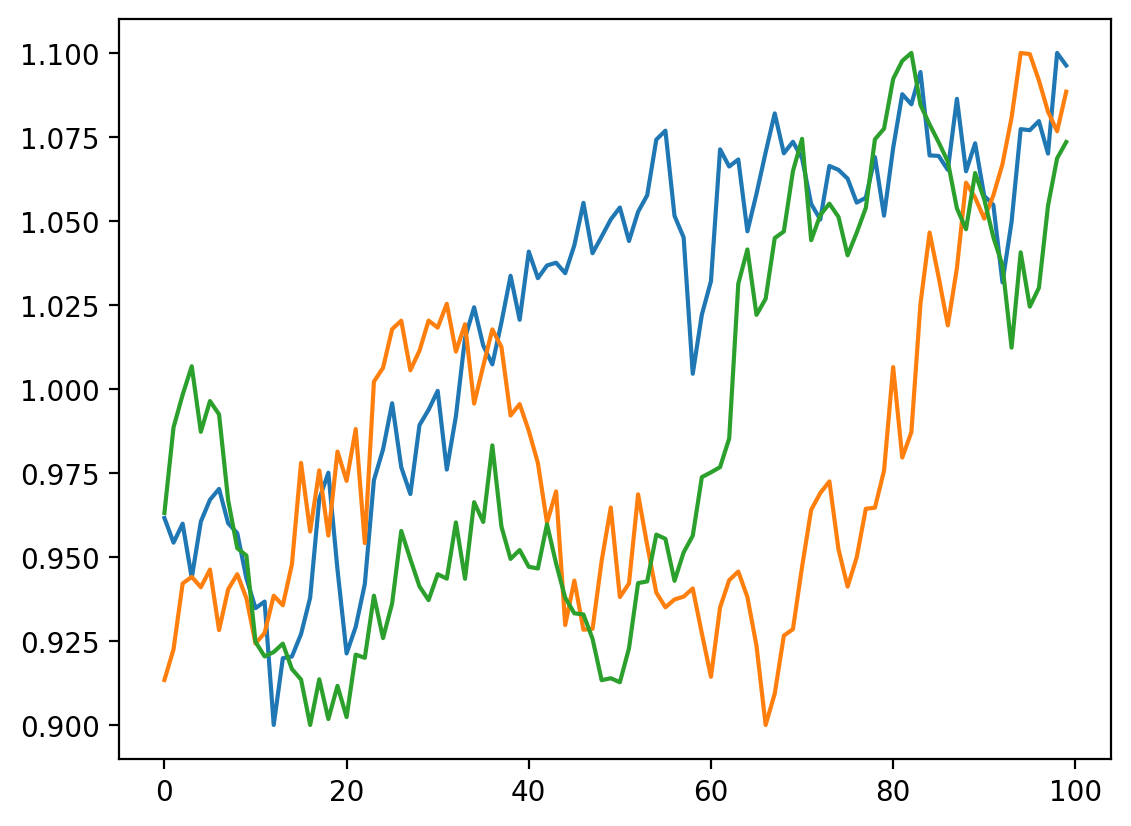

In [79]:
def brownian_noise(batch_sz, channel_sz, n_steps, delta=1.0, start=0.0, range=(0.9, 1.1)):
    steps = np.random.normal(0, delta, size=(batch_sz, channel_sz, n_steps - 1))
    
    path = np.cumsum(steps, axis=2)
    
    start_values = np.full((batch_sz, channel_sz, 1), start)
    path = np.concatenate([start_values, path + start], axis=2)
    
    path_min = path.min(axis=(2), keepdims=True)
    path_max = path.max(axis=(2), keepdims=True)
    path = (path - path_min) / (path_max - path_min)  
    path = path * (range[1] - range[0]) + range[0]   
    
    return path.astype(np.float32)
x = brownian_noise(32, 48, 100)
plt.plot(x[0,0,:])
plt.plot(x[1,0,:])
plt.plot(x[2,1,:])

plt.show

In [80]:
class Conv1dAutoencoder(nn.Module):
    def __init__(self, in_channels=48, latent_channels=12):
        super().__init__()
        self.encoder = Conv1dEncoder_new(in_channels=in_channels, latent_channels=latent_channels)
        self.decoder = Conv1dDecoder_new(in_channels=in_channels, out_channels=latent_channels)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
class Conv1dAutoencoder_multiple_tract(nn.Module):
    def __init__(self, in_channels=5, latent_dim=20):
        super().__init__()
        self.encoder = Conv1dEncoder_multiple_tract(in_channels=in_channels, latent_dim=latent_dim)
        self.decoder = Conv1dDecoder_multiple_tract(latent_dim=latent_dim, out_channels=in_channels)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [166]:
def reconstruction_loss(x, x_hat, kl_div=0.0, reduction="mean"):
    """
    Compute the reconstruction loss (MSE) and optionally add a KL term.
    
    Parameters
    ----------
    x : torch.Tensor
        Original input tensor.
    x_hat : torch.Tensor
        Reconstructed output from the autoencoder.
    kl_div : float
        KL divergence term (VAE only). Defaults to 0 for a standard autoencoder.
    reduction : str
        Reduction mode: "sum" or "mean". Defaults to "sum".
    
    Returns
    -------
    torch.Tensor
        Scalar loss value.
    """
    # e.g. use MSE loss
    recon_loss = F.mse_loss(x_hat, x, reduction="mean")
    total_loss = recon_loss + kl_div
    return total_loss

In [167]:
def random_train_multiple_tracts(self, data, epochs=20, lr=0.001, num_selected_tracts=5, sigma=0.03):
    opt = torch.optim.Adam(self.parameters(), lr=lr)

    for epoch in range(epochs):
        running_loss = 0
        items = 0
        for x, _ in data:  # x shape: (batch_size, 48, 100)
            batch_size = x.size(0)  # 64
            num_tracts = x.size(1)  # 48

            # Randomly select multiple tracts per batch element
            selected_tracts = []  # By the end, will have shape (batch_size, num_selected_tracts, 100)
            for _ in range(num_selected_tracts):
                tract_indices = np.random.randint(0, num_tracts, size=batch_size)
                batch_indices = np.arange(batch_size)
                # Selects specific samples from the batch
                selected_tracts.append(x[batch_indices, tract_indices, :])  # Shape: (batch_size, 100)

            # Stack selected tracts and reshape for processing
            tract_data = torch.stack(selected_tracts, dim=1)  # Shape: (batch_size, num_selected_tracts, 100)
            # print("tract_data", tract_data.shape)
            
            # Apply jitter augmentation to tract data
            tract_data = tract_data.to(torch.float32).numpy()  # Convert to NumPy with float32
            tract_data = aug.jitter(tract_data, sigma=sigma)  # Apply jitter augmentation
            tract_data = torch.tensor(tract_data, dtype=torch.float32).to(device)  # Convert back to PyTorch tensor

            # print("tract_data_part_2", tract_data.shape)
            # # Flatten the data for the model
            # tract_data = tract_data.view(-1, 100).to(device)  # Shape: (batch_size * num_selected_tracts, 100)

            # print("tract_data_part_3", tract_data.shape)
            # # Forward pass
            # tract_data = tract_data.permute(0, 2, 1)  #     Shape: (batch_size, length, num_selected_tracts)
            # print("tract_data_part_4", tract_data.shape)

            opt.zero_grad()

            x_hat = self(tract_data)

            # Calculate loss
            loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")

            # Backward pass
            items += tract_data.size(0)
            running_loss += loss.item()
            loss.backward()
            opt.step()

        print(f"Epoch {epoch+1}, Loss: {running_loss/items:.2f}")

    return self


In [83]:
def train(model, train_loader, val_loader, patience=10, lr_patience=3, epochs=5, lr=1e-3, use_lr_scheduler=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if use_lr_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=lr_patience, verbose=True)
    loss_fn = nn.MSELoss()
    num_no_improve=0
    best_val_loss = 10**10

    for epoch in range(epochs):
        model.train()  # set to train mode
        epoch_loss = 0.0
        num_items = 0
        batch_sz = 32
        batch_per_epoch = 100
        for x, _ in train_loader:
            # x shape: (batch_size, in_channels=48, length=100)
            # move to MPS (or CPU/CUDA) with the same dtype as model
            # x = x.to(device=device, dtype=torch.float32)


            # noise = brownian_noise(x.size(0), x.size(1), 100, delta=0.1, start=0.0, range=(0.9,1.1))
            # x = x * noise
            x = aug.jitter(x.numpy(), sigma=0.01)
            x = torch.tensor(x, dtype=torch.float32).to(device)
            x = x.to(device)

            x_hat = model(x)
            loss = loss_fn(x_hat, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_items += x.size(0)
        avg_loss = epoch_loss / num_items

        print(f"Epoch {epoch+1}/{epochs}, Loss = {avg_loss:.6f}, lr = {optimizer.param_groups[0]['lr']}")

        # Validation loss
        model.eval()
        batch_per_epoch_val = 10
        val_loss = 0.0
        num_items = 0
        with torch.no_grad():
            for x, _ in val_loader:
                
                x = x.to(device)
                x_hat = model(x)
                loss = loss_fn(x_hat, x).item()
                val_loss += loss
                num_items += x.size(0)  

        val_loss /= num_items
        if use_lr_scheduler:
            scheduler.step(val_loss)

        if val_loss > best_val_loss:
            num_no_improve+=1
        else:
            num_no_improve=0
            best_val_loss = val_loss
    
        if num_no_improve != 0:
            print(f"Validation Loss = {val_loss:.6f}, No improvement for {num_no_improve} epochs")
        else:
            print(f"Validation Loss = {val_loss:.6f}")
        
        if num_no_improve == patience:
            print("Early stopping")
            break

    return model

In [71]:
def train_2D_fa(model, data, epochs=100, lr=0.001, sigma=0.02):
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        running_loss = 0
        items = 0
        for x, _ in data:  #shape o x(batch_size 1, 48, 50)
            x = x.unsqueeze(1).to(torch.float32).to(device)

            opt.zero_grad()
            x_hat = model(x)
            loss = reconstruction_loss(x, x_hat, kl_div=0, reduction="sum")

            loss.backward()
            opt.step()

            items += x.size(0)
            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/items:.4f}")

    return model


In [158]:
def train_fa_2(model, data,epochs=100, lr=0.001, sigma=0.02):
    import torch.optim as optim
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=10, factor=0.5, verbose=True)
    
    model.to(device)
    
    for epoch in range(epochs):
        running_loss = 0
        items = 0
        model.train()
        for x, _ in data:  # x shape: [batch, 48, 50]
            # Since data now is already in shape [batch, 48, 50], no extra unsqueeze needed.
            x = x.to(torch.float32).to(device)
            opt.zero_grad()
            x_hat = model(x)
            # loss = F.mse_loss(x_hat, x)
            # loss = nn.MSELoss()(x_hat, x)
            loss = reconstruction_loss(x, x_hat, kl_div=0, reduction="sum")
            loss.backward()
            opt.step()
            items += x.size(0)
            running_loss += loss.item()
        
        avg_loss = running_loss / items
        scheduler.step(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return model 


In [134]:
def train_fa(model, train_loader, val_loader, epochs=100, patience = 10, lr_patience = 3, lr=0.001, sigma=0.02, use_lr_scheduler=False):
   
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if use_lr_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=lr_patience, verbose=True
        ) 
    loss_fn = nn.MSELoss()
    num_no_improve = 0
    best_val_loss = 10**10

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        num_items = 0
        for x, _ in train_loader:
            x = x.to(device)

            x_hat = model(x)
            loss = loss_fn(x_hat, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_items += x.size(0)
        avg_loss = epoch_loss / num_items

        print(
            f"Epoch {epoch+1}/{epochs}, Loss = {avg_loss:.6f},"
            f"lr = {optimizer.param_groups[0]['lr']}"
        )

        model.eval()
        val_loss = 0.0
        num_items = 0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                x_hat = model(x)
                loss = loss_fn(x_hat, x).item()
                val_loss += loss
                num_items += x.size(0)

        val_loss /= num_items
        if use_lr_scheduler:
            scheduler.step(val_loss)

        if val_loss > best_val_loss:
            num_no_improve += 1
        else:
            num_no_improve = 0
            best_val_loss = val_loss

        if num_no_improve != 0:
            print(
                f"Validation Loss = {val_loss:.6f},"
                f"No improvement for {num_no_improve} epochs"
            )
        else:
            print(f"Validation Loss = {val_loss:.6f}")

        if num_no_improve == patience:
            print("Early stopping")
            break

    return model


In [110]:
def train_first_tract_dropout_experiment(
    self, train_data, val_data, epochs=20, lr=0.001, num_selected_tracts=5, sigma=0.03
):
    opt = torch.optim.Adam(self.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    train_rmse_per_epoch = []
    val_rmse_per_epoch = []
    best_val_loss = float('inf')  # Track the best (lowest) validation RMSE overall

    for epoch in range(epochs):
        # Training
        self.train()
        running_loss = 0
        running_rmse = 0
        items = 0

        for x, _ in train_data:  # x shape: (batch_size, 48, 100)
            batch_size = x.size(0)
            # For simplicity, using only the first tract in training

            tract_data = x[:, 0:1, :] #keeps it (batch_size, 1, 100)    

            # Apply jitter augmentation
            tract_data = tract_data.to(torch.float32).numpy()
            tract_data = aug.jitter(tract_data, sigma=sigma)
            tract_data = torch.tensor(tract_data, dtype=torch.float32).to(device)

            # Forward pass
            opt.zero_grad()
            x_hat = self(tract_data)

            # Calculate loss
            loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")
            # Compute RMSE for the batch
            batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

            # Backward pass
            loss.backward()
            opt.step()

            items += tract_data.size(0)
            running_loss += loss.item()
            running_rmse += batch_rmse.item() * tract_data.size(0)  # Weighted sum

        scheduler.step(running_loss / items)
        avg_train_rmse = running_rmse / items
        train_rmse_per_epoch.append(avg_train_rmse)

        # Validation
        self.eval()
        val_rmse = 0
        val_items = 0

        with torch.no_grad():
            for x, _ in val_data:
                batch_size = x.size(0)
                # For simplicity, using the first tract in validation as well
                tract_data = x[:, 0:1, :]

                # Apply jitter augmentation
                
                tract_data = tract_data.to(torch.float32).numpy()
                tract_data = aug.jitter(tract_data, sigma=sigma)
                tract_data = torch.tensor(tract_data, dtype=torch.float32).to(device)

                # Forward pass
                x_hat = self(tract_data)

                # Compute RMSE for the batch
                batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

                val_items += tract_data.size(0)
                val_rmse += batch_val_rmse.item() * tract_data.size(0)

        avg_val_rmse = val_rmse / val_items
        val_rmse_per_epoch.append(avg_val_rmse)

        # Update best validation loss if improved
        if avg_val_rmse < best_val_loss:
            best_val_loss = avg_val_rmse

        print(
            f"Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}"
        )

    return train_rmse_per_epoch, val_rmse_per_epoch, best_val_loss



Training with dropout = 0
Epoch 1, Train RMSE: 0.0854, Val RMSE: 0.0831
Epoch 2, Train RMSE: 0.0724, Val RMSE: 0.0646
Epoch 3, Train RMSE: 0.0581, Val RMSE: 0.0545
Epoch 4, Train RMSE: 0.0517, Val RMSE: 0.0517
Epoch 5, Train RMSE: 0.0447, Val RMSE: 0.0406
Epoch 6, Train RMSE: 0.0388, Val RMSE: 0.0370
Epoch 7, Train RMSE: 0.0364, Val RMSE: 0.0351
Epoch 8, Train RMSE: 0.0349, Val RMSE: 0.0340
Epoch 9, Train RMSE: 0.0340, Val RMSE: 0.0332
Epoch 10, Train RMSE: 0.0333, Val RMSE: 0.0329
Epoch 11, Train RMSE: 0.0337, Val RMSE: 0.0332
Epoch 12, Train RMSE: 0.0330, Val RMSE: 0.0326
Epoch 13, Train RMSE: 0.0326, Val RMSE: 0.0325
Epoch 14, Train RMSE: 0.0323, Val RMSE: 0.0321
Epoch 15, Train RMSE: 0.0319, Val RMSE: 0.0317
Epoch 16, Train RMSE: 0.0318, Val RMSE: 0.0317
Epoch 17, Train RMSE: 0.0317, Val RMSE: 0.0313
Epoch 18, Train RMSE: 0.0313, Val RMSE: 0.0311
Epoch 19, Train RMSE: 0.0314, Val RMSE: 0.0310
Epoch 20, Train RMSE: 0.0312, Val RMSE: 0.0311
Epoch 21, Train RMSE: 0.0311, Val RMSE: 0.

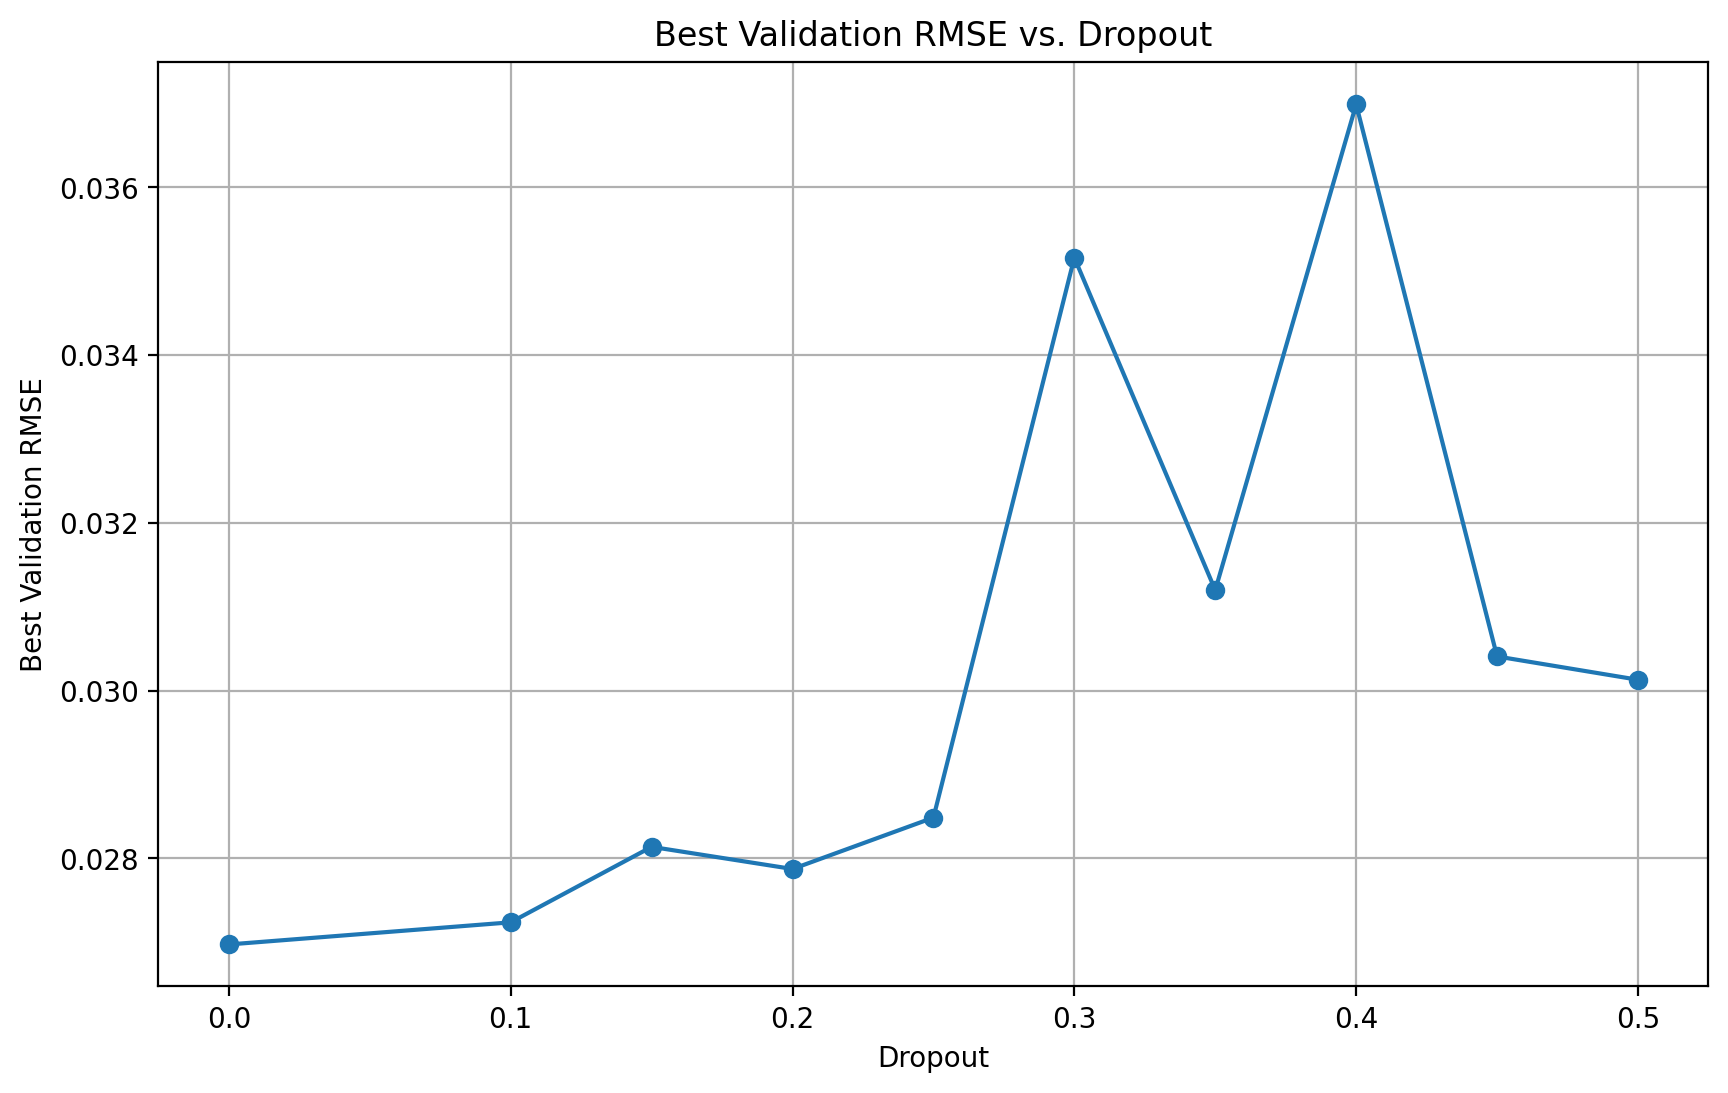

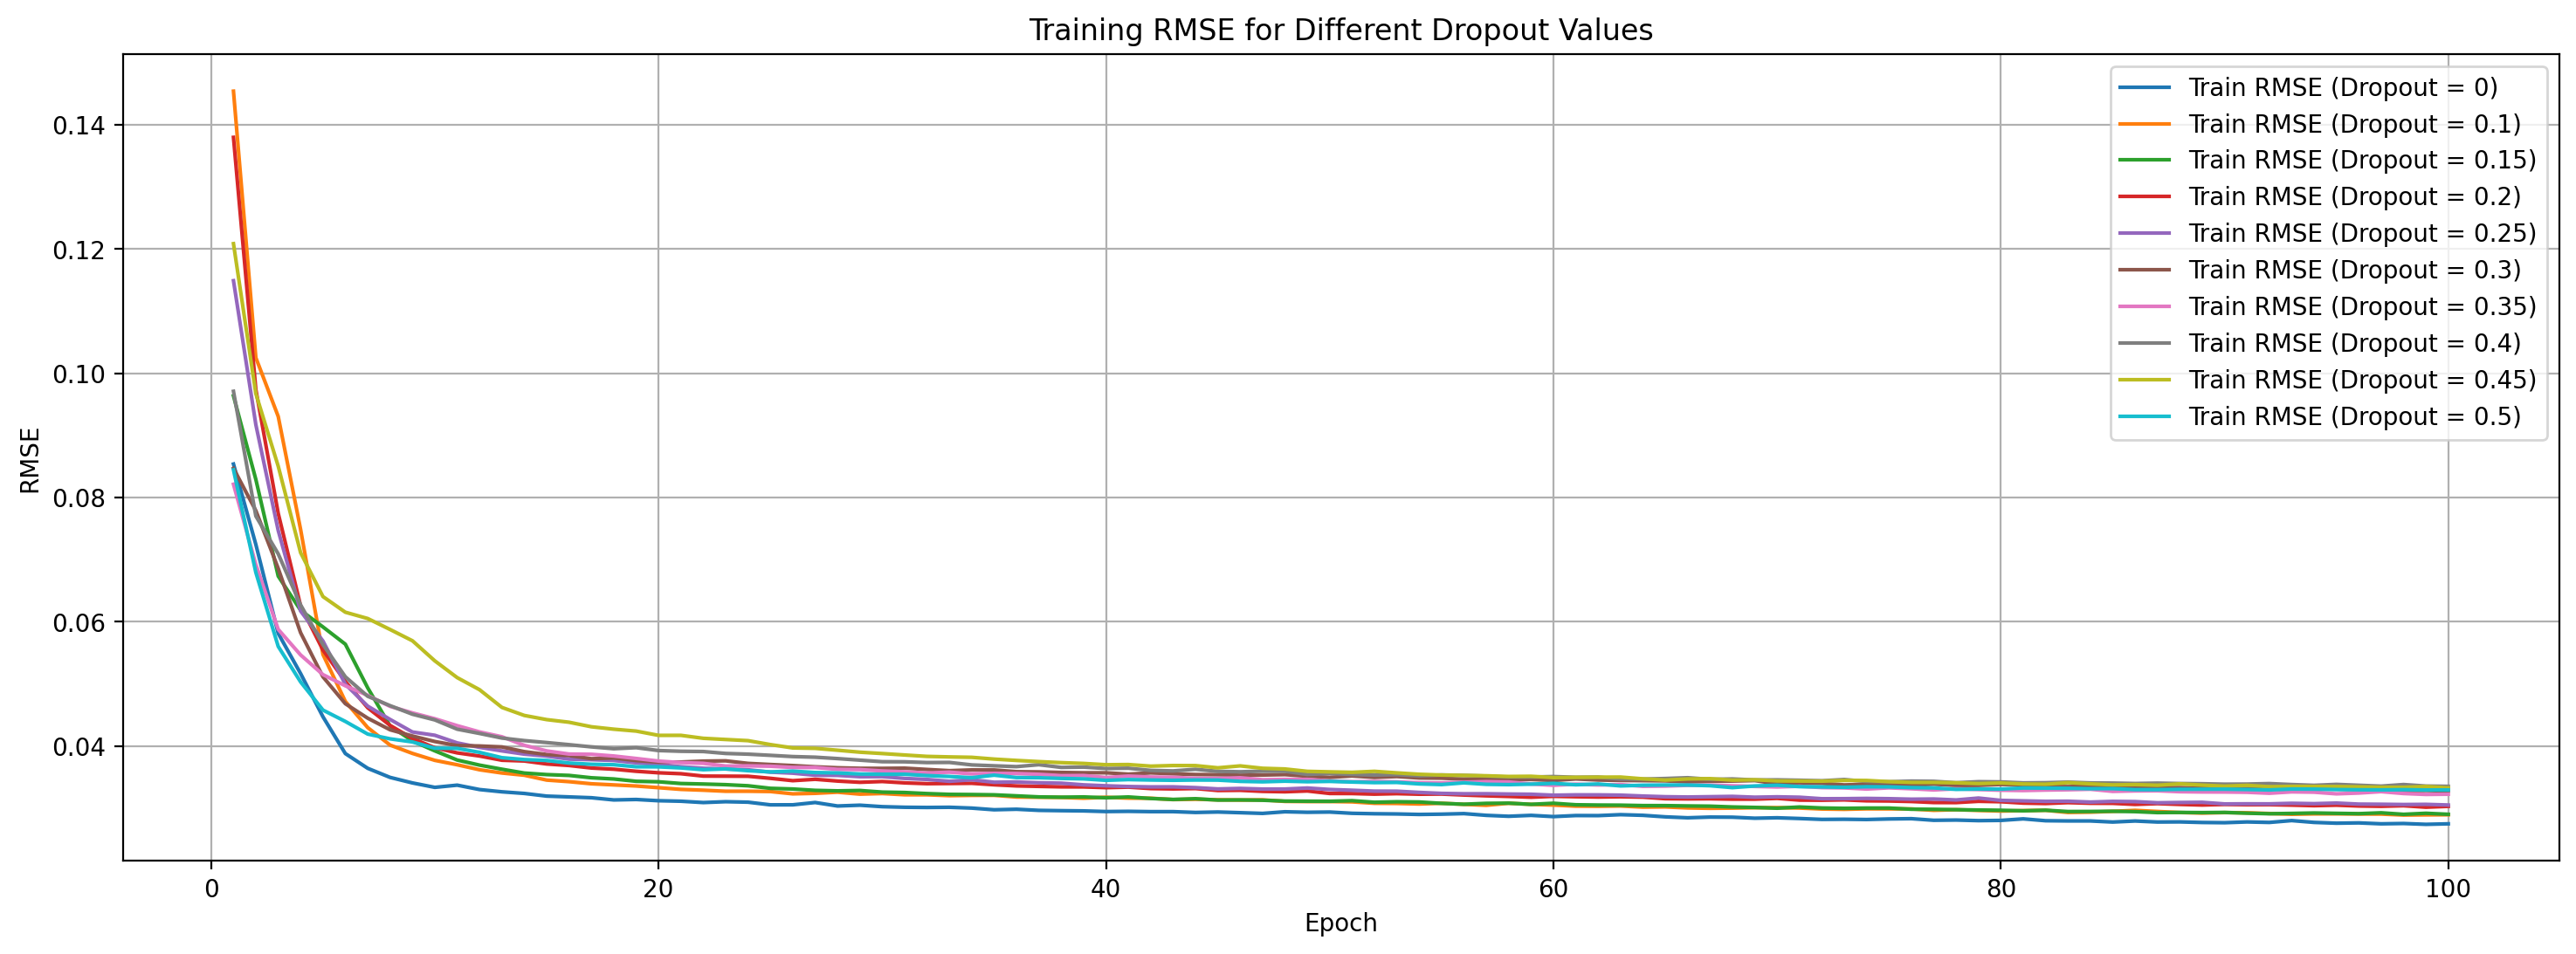

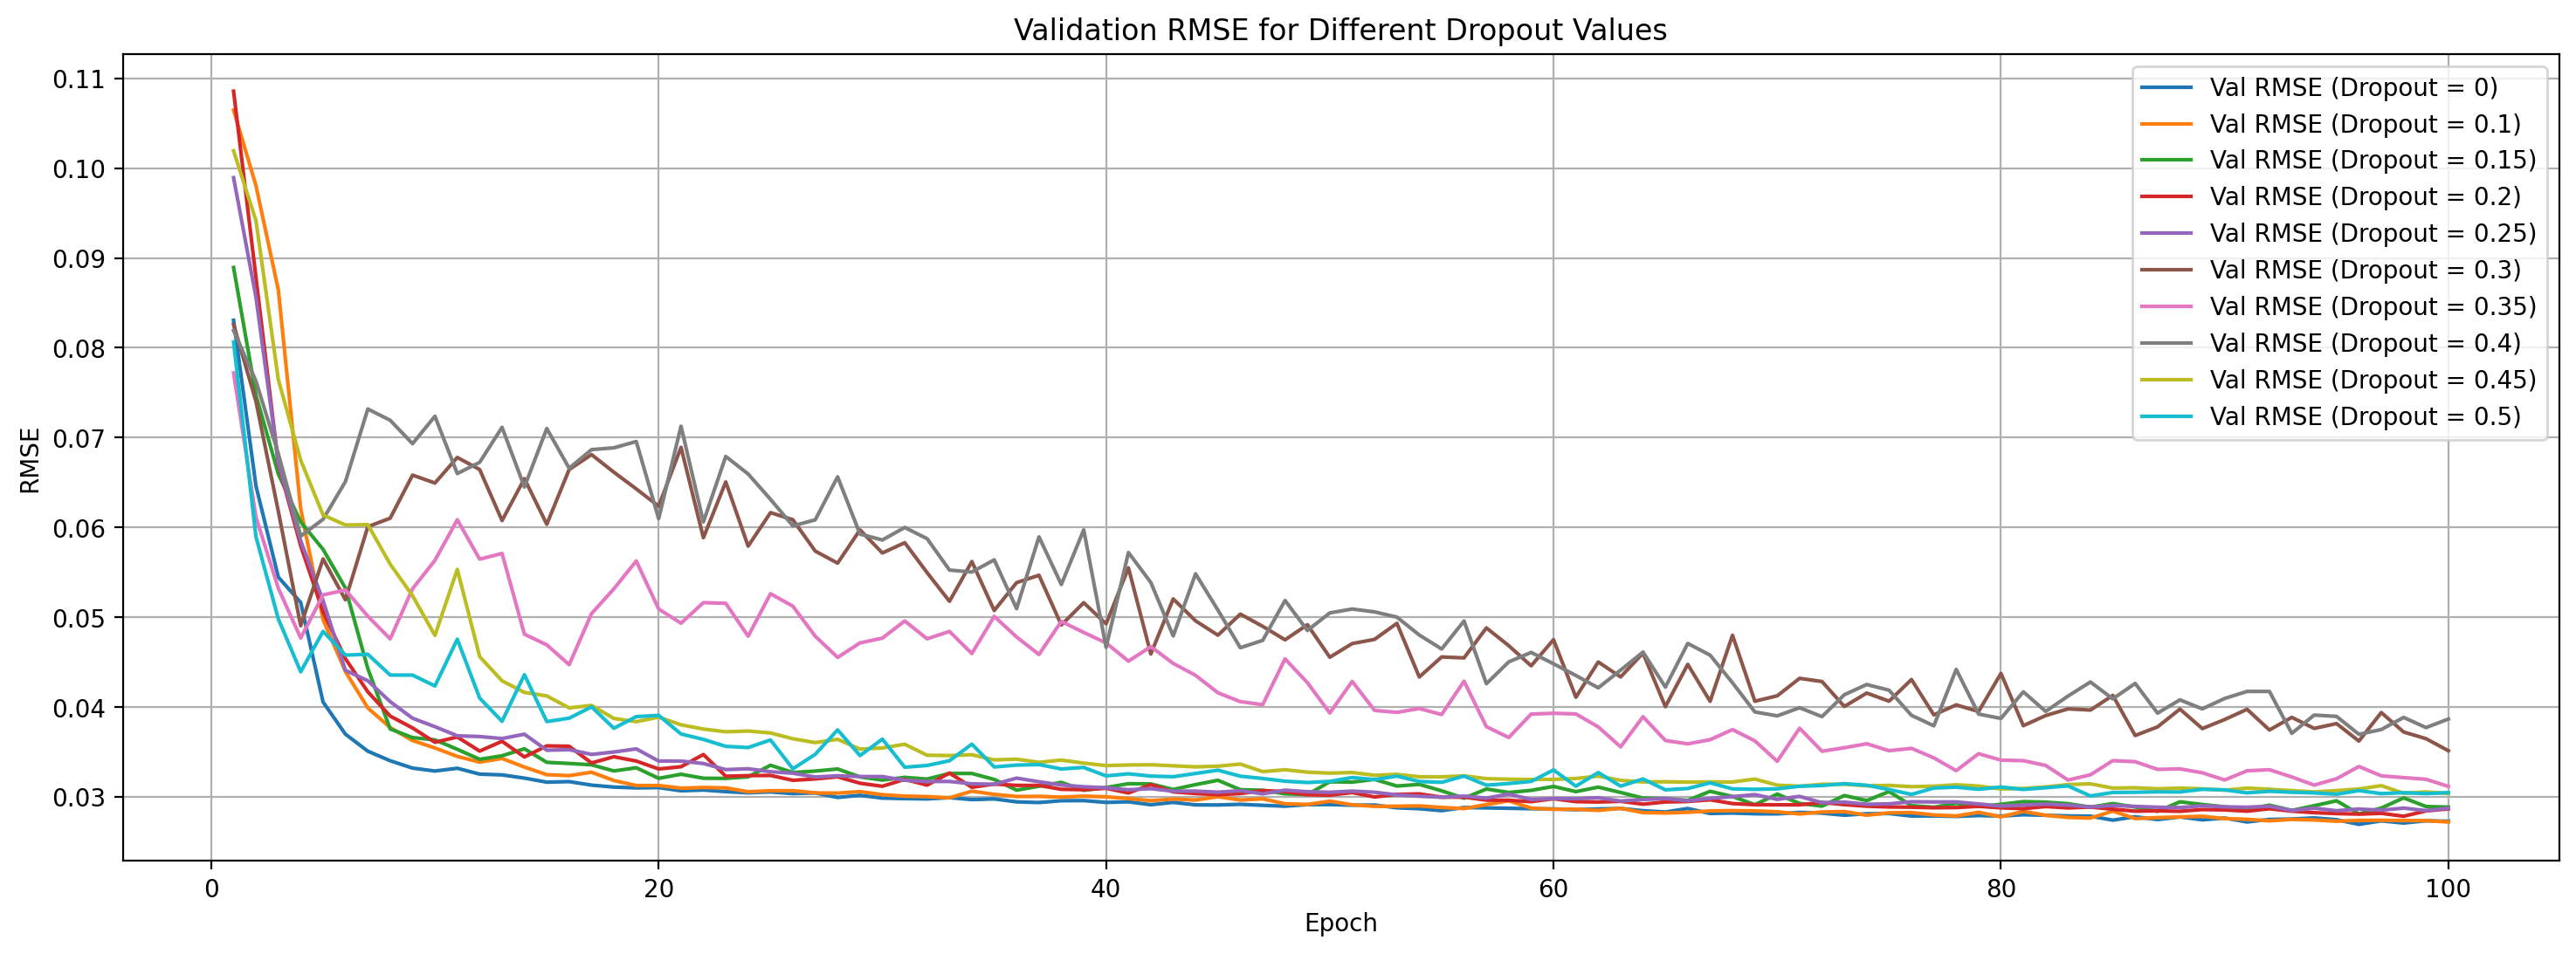

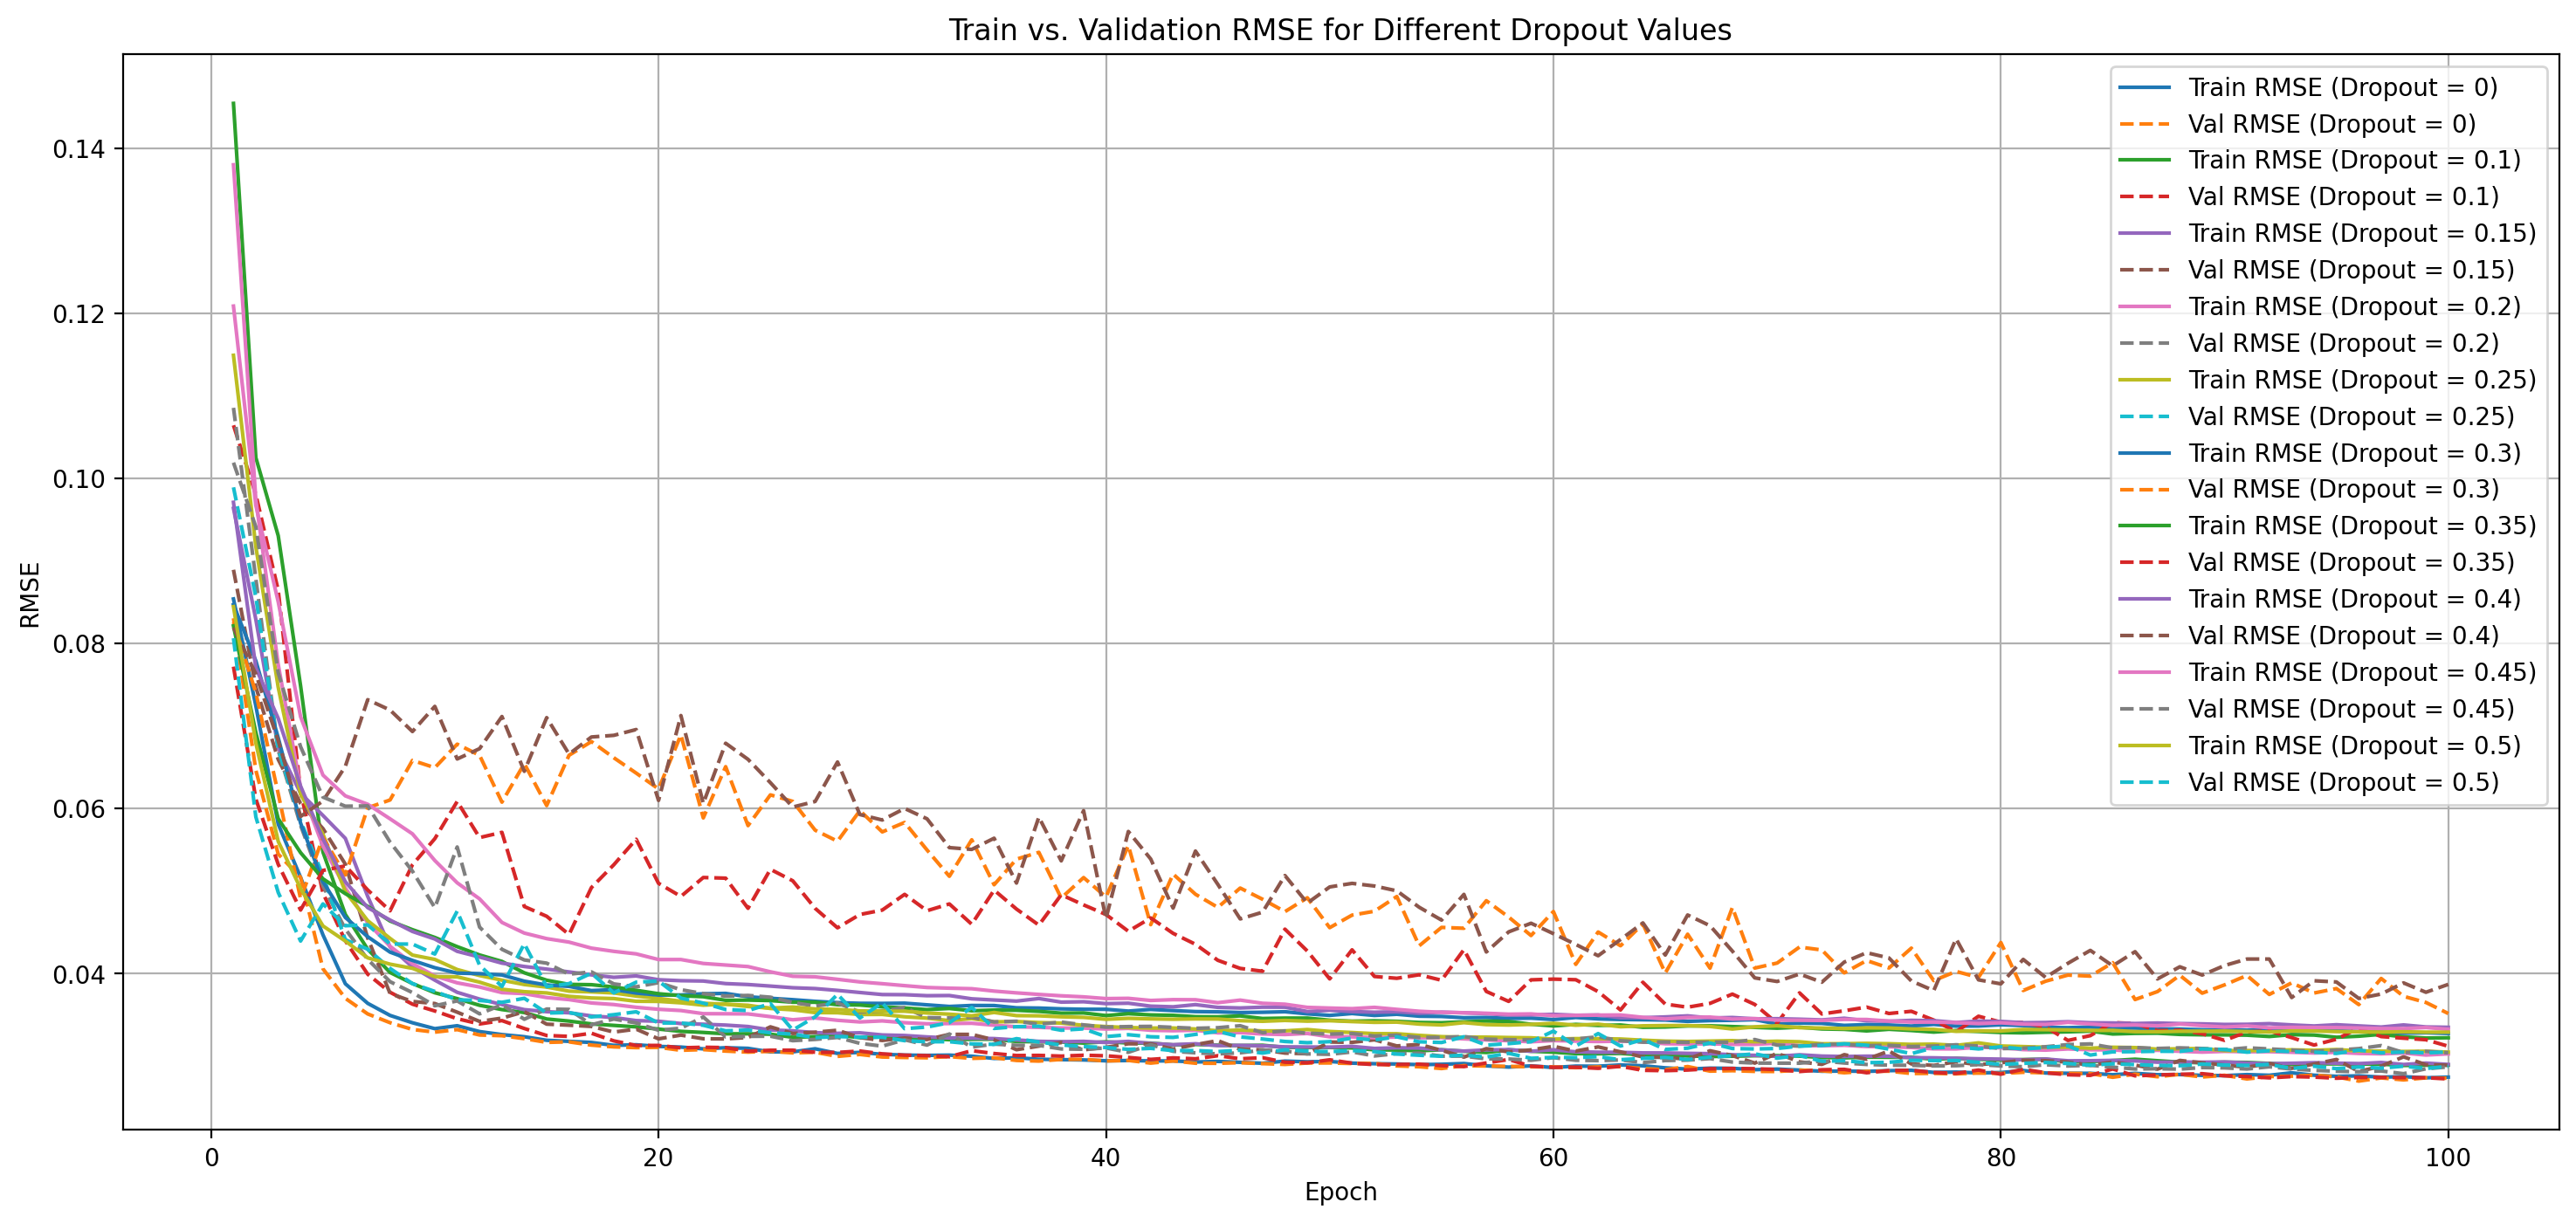

In [111]:
import matplotlib.pyplot as plt


dropout_values = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
train_rmse_results = {}
val_rmse_results = {}
best_val_results = {}

for dropout in dropout_values:
    print(f"\nTraining with dropout = {dropout}")
    vae_one_tract = Conv1DAutoencoder_one_tract(latent_dims=20, dropout=dropout).to(device)
    train_rmse, val_rmse, best_val_loss = train_first_tract_dropout_experiment(
        vae_one_tract, train_loader, val_loader, epochs=100, lr=1e-3, num_selected_tracts=8
    )
    train_rmse_results[dropout] = train_rmse
    val_rmse_results[dropout] = val_rmse
    best_val_results[dropout] = best_val_loss

# Plot best validation RMSE for each dropout value
plt.figure(figsize=(10, 6))
dropout_keys = sorted(best_val_results.keys())
best_vals = [best_val_results[d] for d in dropout_keys]
plt.plot(dropout_keys, best_vals, marker='o')
plt.xlabel("Dropout")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs. Dropout")
plt.grid()
plt.show()

# Plot 1: Training RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()

# Plot 2: Validation RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()

# Plot 3: Both Training and Validation RMSE
plt.figure(figsize=(18, 8))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        linestyle="--",
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train vs. Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()


In [115]:
def train_multiple_latent_dimensions(train_data, val_data, epochs=100, lr=0.001, sigma=0.03):
    latent_dims = list(range(10, 101, 10))  # [10, 20, ..., 100]
    results = []

    for latent_dim in latent_dims:
        print(f"Training Autoencoder with Latent Dimension: {latent_dim}")

        # Initialize a new autoencoder for each latent dimension
        model = Conv1DAutoencoder_one_tract(latent_dims=latent_dim).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)

        train_rmse_per_epoch = []
        val_rmse_per_epoch = []
        best_val_loss = float('inf')  # Track the best (lowest) validation RMSE
        best_model_state = None     # Save the best model state

        for epoch in range(epochs):
            # Training
            model.train()
            running_loss = 0
            running_rmse = 0
            items = 0

            for x, _ in train_data:  # x shape: (batch_size, 48, 100)
                batch_size = x.size(0)
                tract_data = x[:, 0:1, :].to(device)  # Shape: (batch_size, 100)

                opt.zero_grad()
                x_hat = model(tract_data)

                loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")
                batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

                loss.backward()
                opt.step()

                items += tract_data.size(0)
                running_loss += loss.item()
                running_rmse += batch_rmse.item() * tract_data.size(0)  # Weighted sum

            scheduler.step(running_loss / items)
            avg_train_rmse = running_rmse / items
            train_rmse_per_epoch.append(avg_train_rmse)

            # Validation
            model.eval()
            val_rmse = 0
            val_items = 0

            with torch.no_grad():
                for x, _ in val_data:
                    tract_data = x[:, 0:1, :].to(device)
                    x_hat = model(tract_data)
                    batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))
                    val_items += tract_data.size(0)
                    val_rmse += batch_val_rmse.item() * tract_data.size(0)

            avg_val_rmse = val_rmse / val_items
            val_rmse_per_epoch.append(avg_val_rmse)

            # Check and save the best model state if current validation loss is lower
            if avg_val_rmse < best_val_loss:
                best_val_loss = avg_val_rmse
                best_model_state = model.state_dict()

            print(f"Latent Dim {latent_dim} - Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}")

        results.append({
            "latent_dim": latent_dim,
            "train_rmse_per_epoch": train_rmse_per_epoch,
            "val_rmse_per_epoch": val_rmse_per_epoch,
            "best_val_loss": best_val_loss,
            "best_model_state": best_model_state  # Optional: Save checkpoint for later use
        })

    return results

In [ ]:
results = train_multiple_latent_dimensions(train_loader, val_loader)

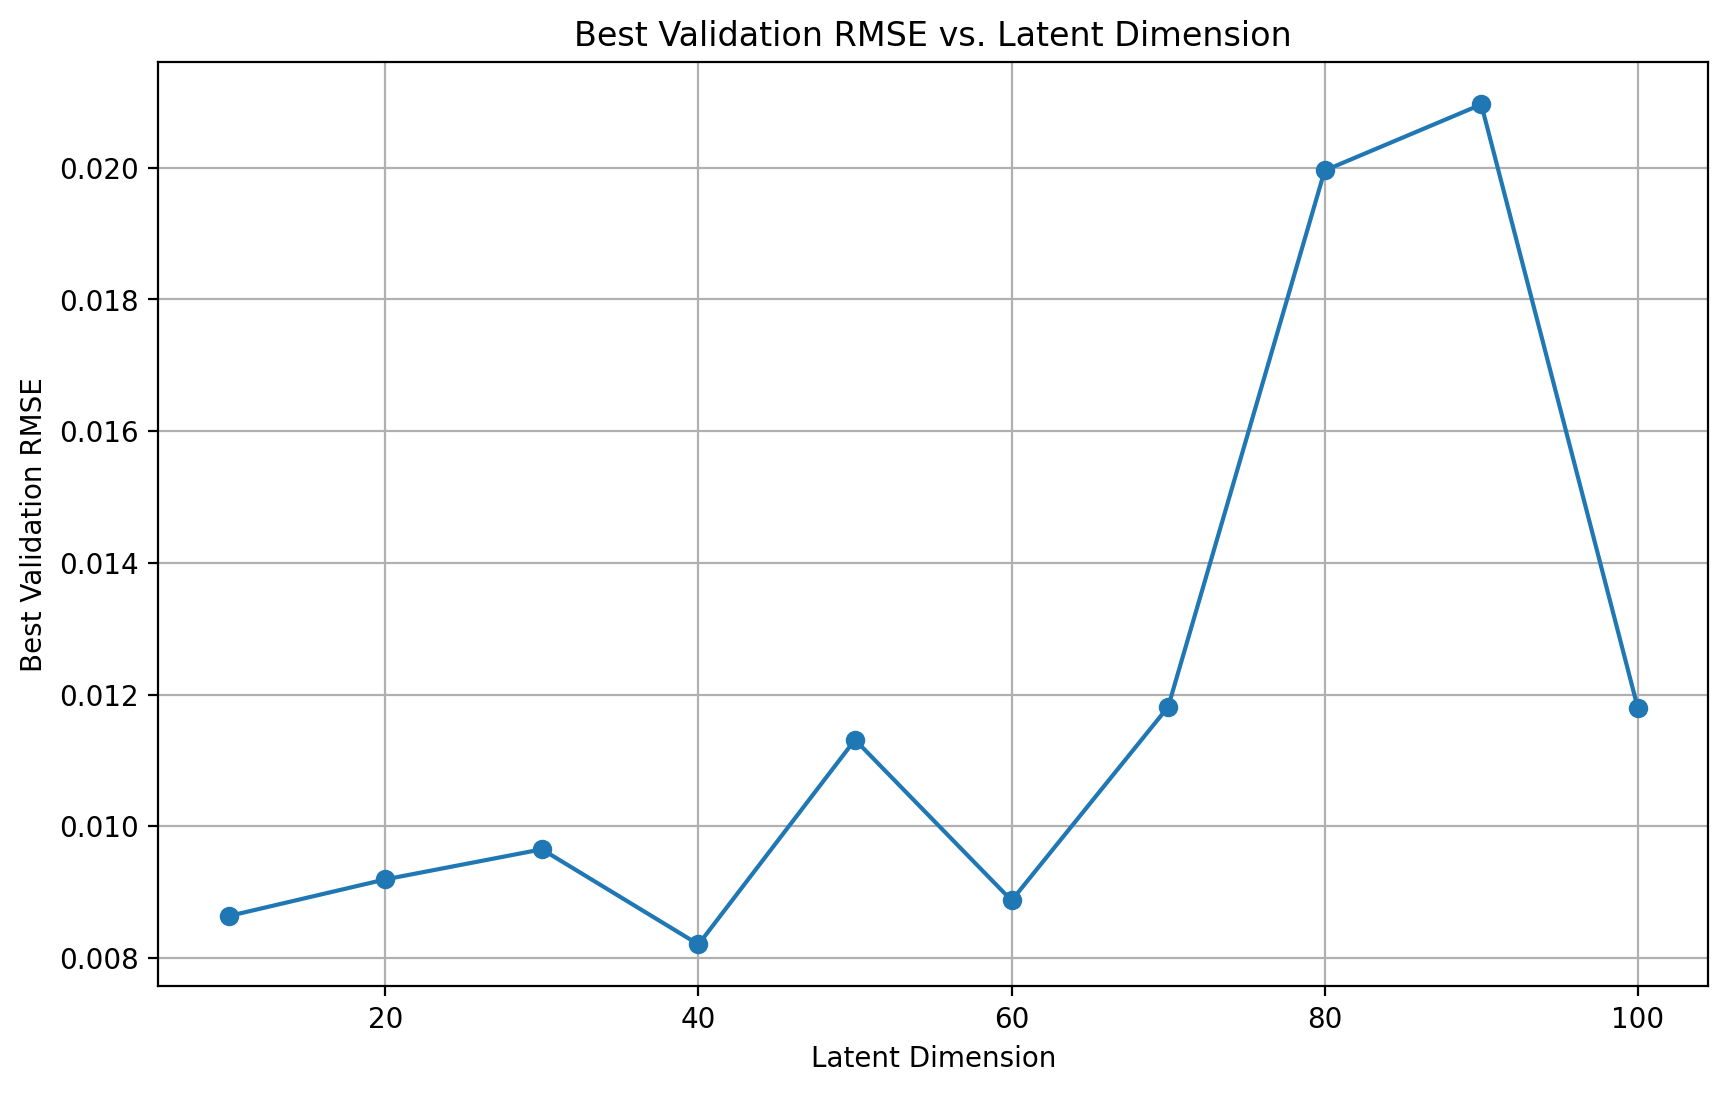

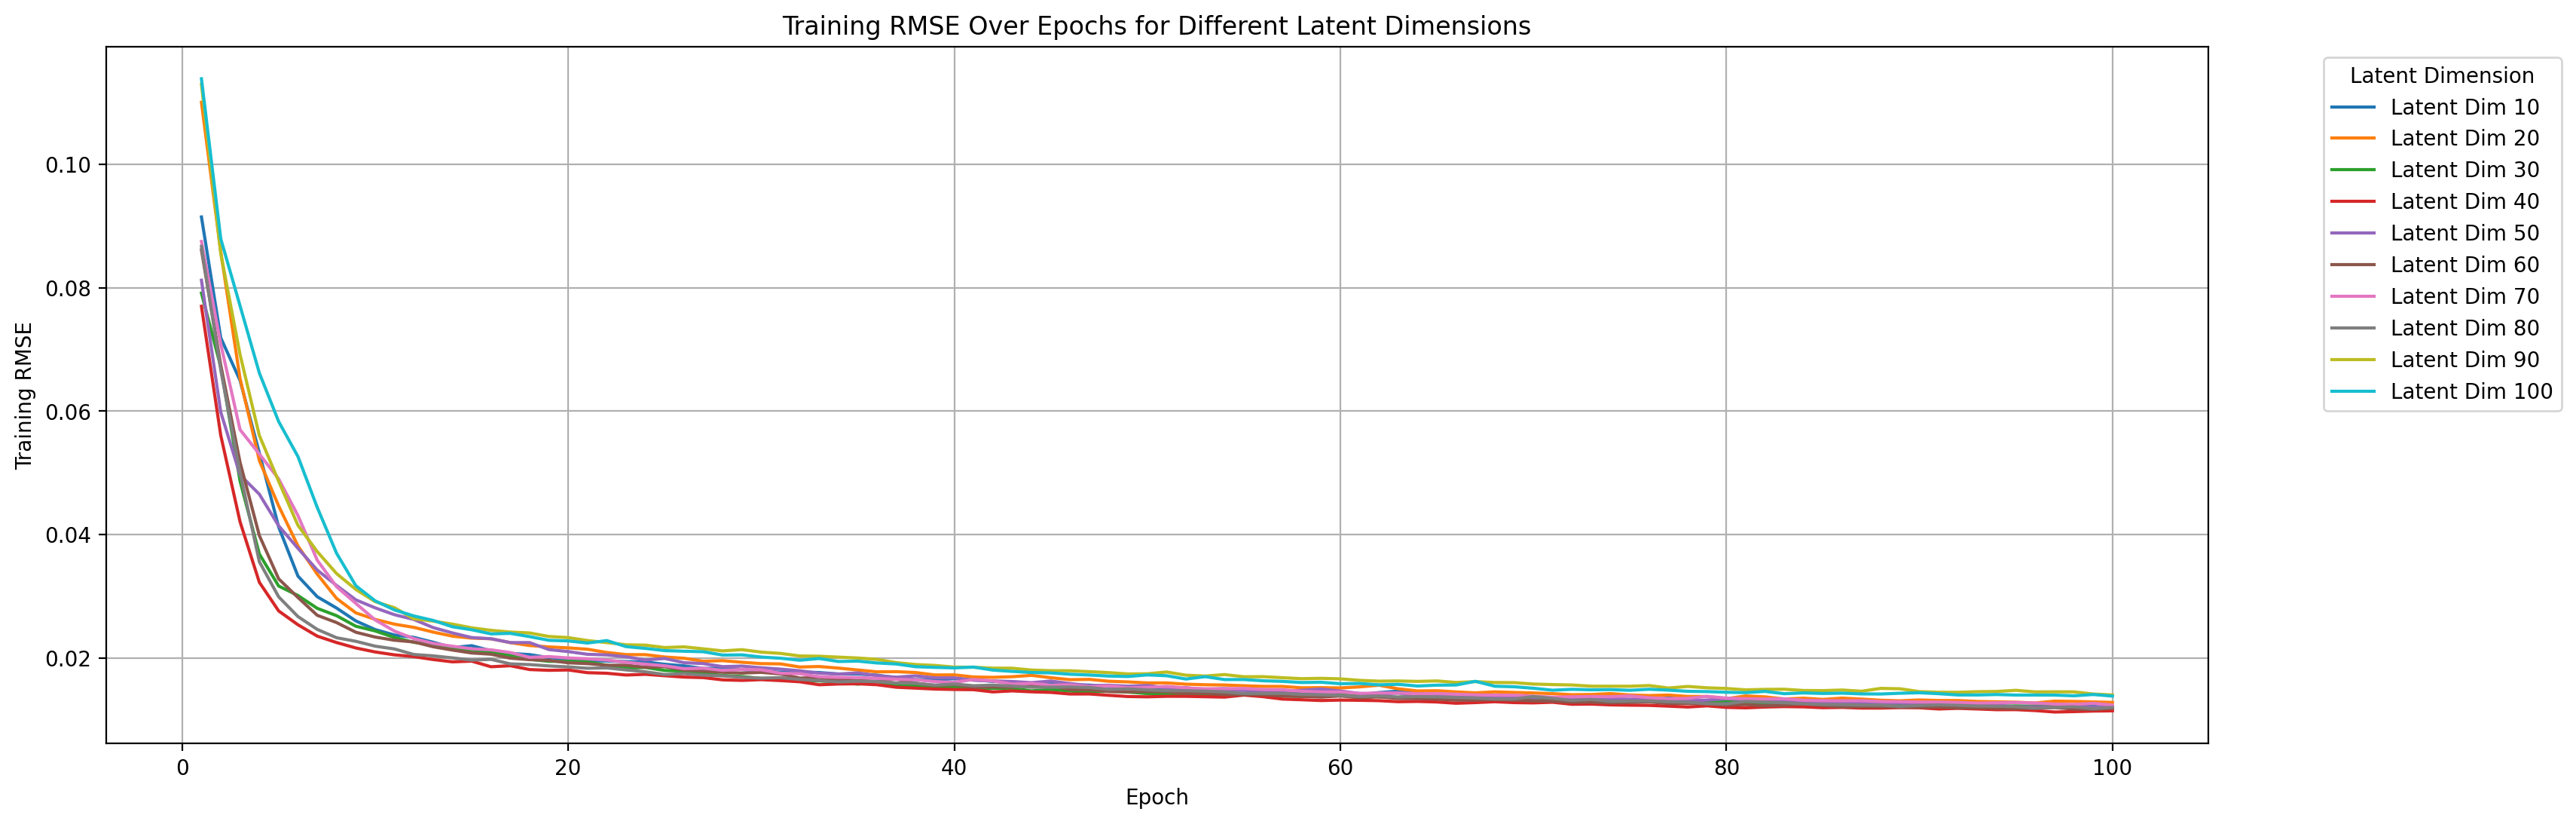

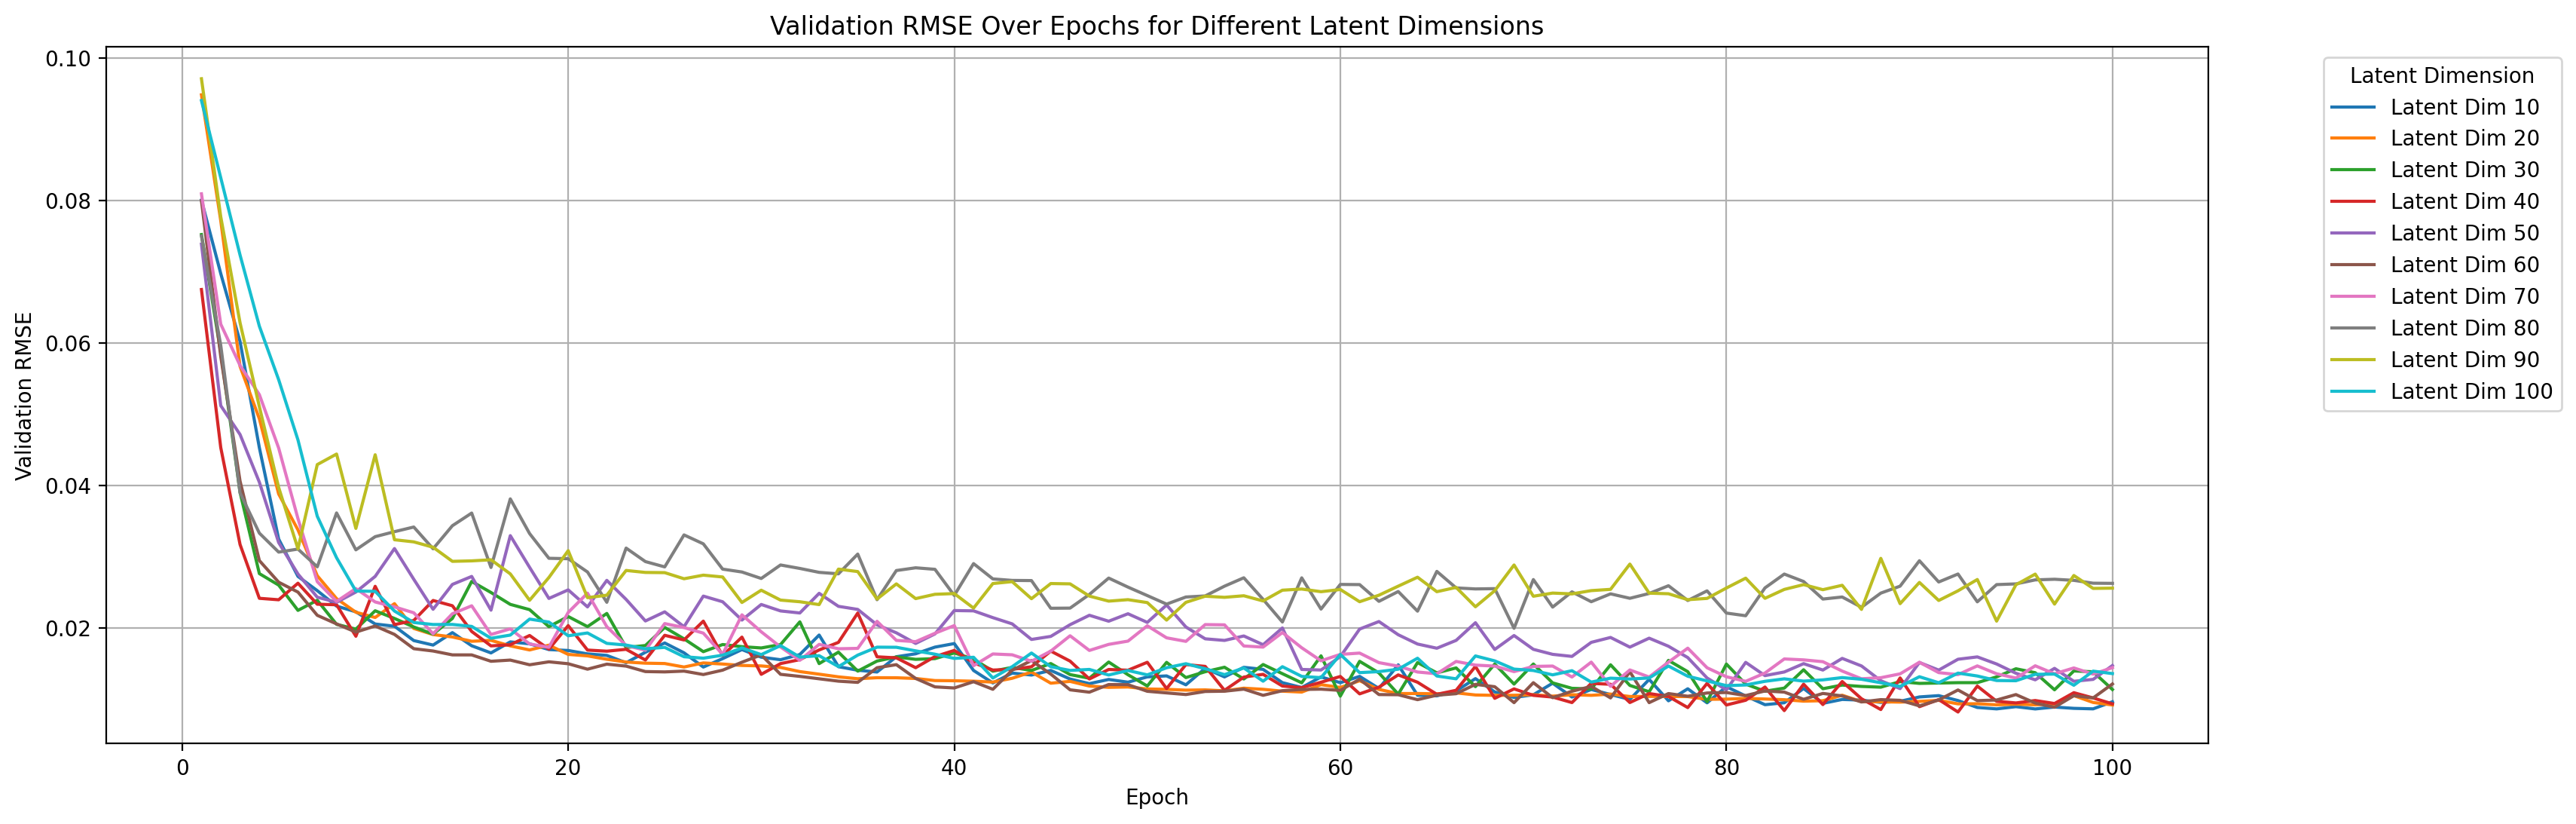

In [118]:
import matplotlib.pyplot as plt

latent_dims = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

latent_dims = [result["latent_dim"] for result in results]
best_val_losses = [result["best_val_loss"] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(latent_dims, best_val_losses, marker='o')
plt.xlabel("Latent Dimension")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs. Latent Dimension")
plt.grid()
plt.show()

#plot 1, train rmse vs epoch
plt.figure(figsize=(18, 6))
for result in results: 
    plt.plot(
        range(1, len(result["train_rmse_per_epoch"]) + 1),
        result["train_rmse_per_epoch"],
        label=f"Latent Dim {result['latent_dim']}",  
    )
plt.xlabel("Epoch")
plt.ylabel("Training RMSE")
plt.title("Training RMSE Over Epochs for Different Latent Dimensions")
plt.legend(title="Latent Dimension", bbox_to_anchor=(1.05, 1), loc="upper left")  
plt.grid()
plt.show()

#plot 1, val rmse vs epoch
plt.figure(figsize=(18, 6))
for result in results:  
    plt.plot(
        range(1, len(result["val_rmse_per_epoch"]) + 1),
        result["val_rmse_per_epoch"],
        label=f"Latent Dim {result['latent_dim']}", 
    )
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE Over Epochs for Different Latent Dimensions")
plt.legend(title="Latent Dimension", bbox_to_anchor=(1.05, 1), loc="upper left")  
plt.grid()
plt.show()


In [161]:
latent_dims = 50
# conv_autoencoder = Conv1DAutoencoder_one_tract(latent_dim=latent_dims).to(device)
# conv_autoencoder_2D_fa = Conv2DAutoencoder_fa(latent_dim=latent_dims).to(device)
conv_autoencoder_1D_fa = Conv1DAutoencoder_fa(latent_dims=latent_dims).to(device)
# conv_autoencoder = train_first_tract(conv_autoencoder, train_loader, epochs=100, lr=0.001, sigma=0.02)
# conv_autoencoder_2D_fa = train_2D_fa(conv_autoencoder_2D_fa, fa_train_loader, epochs=1000, lr=0.001, sigma=0.02)
# train_fa(model, train_loader, val_loader, epochs=100, lr_patience = 3, lr=0.001, sigma=0.02, use_lr_scheduler=False):

conv_autoencoder_1D_fa = train_fa_2(conv_autoencoder_1D_fa, fa_train_loader, epochs=1000, lr=0.001, sigma=0.02)
# conv_autoencoder_1D_fa = train_fa(model = conv_autoencoder_1D_fa, train_loader=fa_train_loader, val_loader=fa_val_loader, epochs=1000, lr=0.001, sigma=0.02)

Epoch 1, Loss: 29.4494
Epoch 2, Loss: 24.6948
Epoch 3, Loss: 22.7605
Epoch 4, Loss: 19.4399
Epoch 5, Loss: 15.4050
Epoch 6, Loss: 13.3814
Epoch 7, Loss: 12.0519
Epoch 8, Loss: 11.0608
Epoch 9, Loss: 10.6627
Epoch 10, Loss: 10.4080
Epoch 11, Loss: 10.2196
Epoch 12, Loss: 10.0213
Epoch 13, Loss: 9.8336
Epoch 14, Loss: 9.6322
Epoch 15, Loss: 9.5070
Epoch 16, Loss: 9.3023
Epoch 17, Loss: 9.0788
Epoch 18, Loss: 9.0715
Epoch 19, Loss: 8.9227
Epoch 20, Loss: 8.7533
Epoch 21, Loss: 8.7074
Epoch 22, Loss: 8.7131
Epoch 23, Loss: 8.5584
Epoch 24, Loss: 8.3514
Epoch 25, Loss: 8.2872
Epoch 26, Loss: 8.1933
Epoch 27, Loss: 8.1088
Epoch 28, Loss: 8.2659
Epoch 29, Loss: 8.0892
Epoch 30, Loss: 7.9570
Epoch 31, Loss: 7.8666
Epoch 32, Loss: 7.8527
Epoch 33, Loss: 7.8036
Epoch 34, Loss: 7.8306
Epoch 35, Loss: 7.7153
Epoch 36, Loss: 7.6568
Epoch 37, Loss: 7.6288
Epoch 38, Loss: 7.6226
Epoch 39, Loss: 7.5826
Epoch 40, Loss: 7.5868
Epoch 41, Loss: 7.5180
Epoch 42, Loss: 7.4087
Epoch 43, Loss: 7.3942
Epoch 44

In [162]:
sample1 = fa_test_loader.dataset[0][0] 
sample2 = fa_test_loader.dataset[1][0] 
sample3 = fa_test_loader.dataset[2][0]
sample4 = fa_test_loader.dataset[3][0]

input_data1 = sample1.to(torch.float32).to(device)  
input_data2 = sample2.to(torch.float32).to(device)
input_data3 = sample3.to(torch.float32).to(device)
input_data4 = sample4.to(torch.float32).to(device)

with torch.no_grad():
    output1 = conv_autoencoder_1D_fa(input_data1)
    output2 = conv_autoencoder_1D_fa(input_data2)
    output3 = conv_autoencoder_1D_fa(input_data3)
    output4 = conv_autoencoder_1D_fa(input_data4)

orig1 = input_data1.cpu().detach().squeeze().numpy()
recon1 = output1.cpu().detach().squeeze().numpy()

orig2 = input_data2.cpu().detach().squeeze().numpy()
recon2 = output2.cpu().detach().squeeze().numpy()

orig3 = input_data3.cpu().detach().squeeze().numpy()
recon3 = output3.cpu().detach().squeeze().numpy()

orig4 = input_data4.cpu().detach().squeeze().numpy()
recon4 = output4.cpu().detach().squeeze().numpy()

In [163]:
print("Original shape:", sample1.shape)
print("altered original", input_data1.shape)
print("Original shape:", orig1.shape)
print("reconstruction", recon1.shape)

Original shape: torch.Size([48, 50])
altered original torch.Size([48, 50])
Original shape: (48, 50)
reconstruction (48, 50)


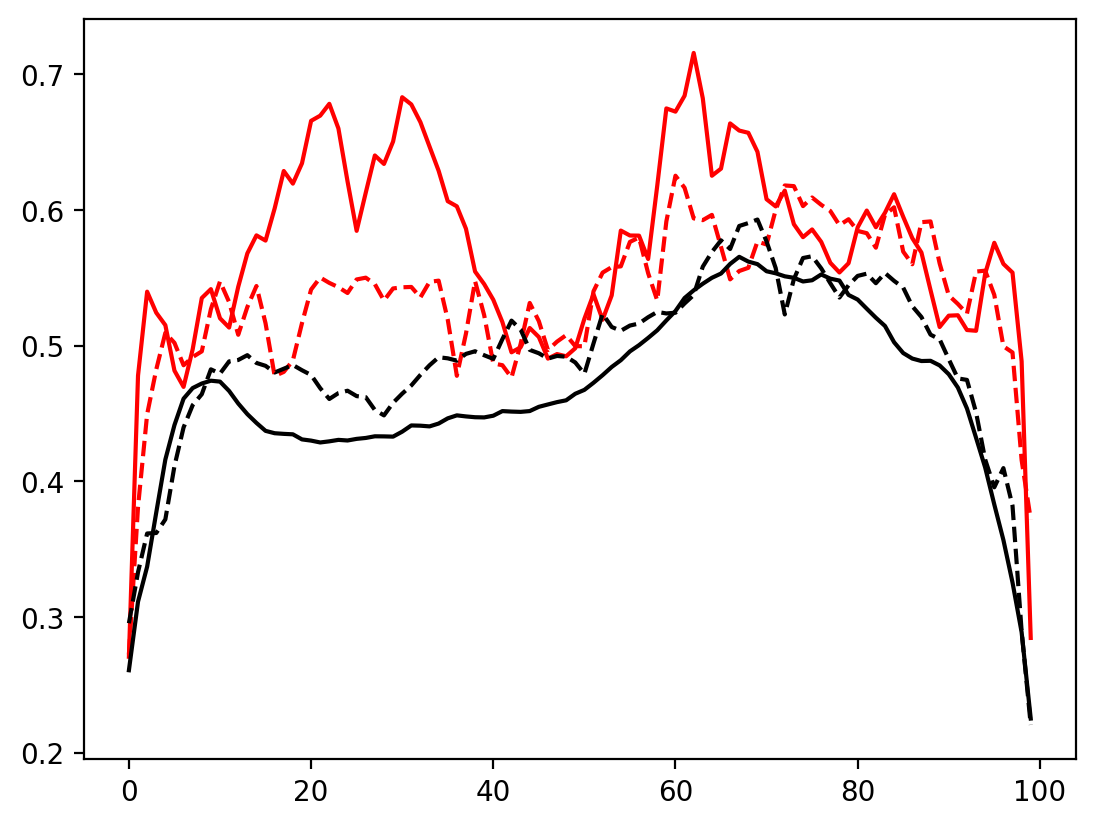

In [165]:
plt.plot(orig1.flatten()[0:100], color='red')
plt.plot(recon1.flatten()[0:100], color='red', linestyle='dashed') 
# plt.plot(orig2.flatten()[0:100], color='green')
# plt.plot(recon2.flatten()[0:100], color='green', linestyle='dashed')
# plt.plot(orig3.flatten()[0:100], color='blue')
# plt.plot(recon3.flatten()[0:100], color='blue', linestyle='dashed')
plt.plot(orig4.flatten()[0:100], color='black')
plt.plot(recon4.flatten()[0:100], color='black', linestyle='dashed')

In [ ]:
print(test_loader.dataset[0][0][0].unsqueeze(0).shape)
print(test_loader.dataset[1][0][0].unsqueeze(0).shape)

input_data = test_loader.dataset[0][0][0].unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, 100)
output3 = conv_autoencoder.forward(input_data)
input_data2 = test_loader.dataset[1][0][0].unsqueeze(0).unsqueeze(0).to(dev2ice)  # (1, 1, 100)
output4 = conv_autoencoder.forward(input_data2)

print(output3.size())

torch.Size([1, 100])
torch.Size([1, 100])
torch.Size([1, 1, 98])


In [46]:
def train_fa_experiment(model, train_data, val_data, epochs=20, lr=0.001, sigma=0.02):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    train_rmse_per_epoch = []
    val_rmse_per_epoch = []

    for epoch in range(epochs):
        running_loss = 0
        running_rmse = 0
        items = 0
        model.train()
        for x, _ in train_data:  # x shape: (batch_size, 48, 100)
            x = x.to(torch.float32).to(device)
            opt.zero_grad()
            x_hat = model(x)
            loss = reconstruction_loss(x, x_hat, kl_div=0, reduction="sum")
            batch_rmse = torch.sqrt(F.mse_loss(x, x_hat, reduction="mean"))
            running_rmse += batch_rmse.item() * x.size(0)  # Weighted sum of RMSE
            items += x.size(0)
            running_loss += loss.item()

            loss.backward()
            opt.step()
            

        # print(f"Epoch {epoch+1}, Loss: {running_loss/items:.2f}")
        scheduler.step(running_loss/items)


        # Average RMSE for training epoch
        avg_train_rmse = running_rmse / items
        train_rmse_per_epoch.append(avg_train_rmse)

        # Validation
        model.eval()
        val_rmse = 0
        val_items = 0

        with torch.no_grad():
            for x, _ in val_data:
                x = x.to(torch.float32).to(device)

                # Forward pass
                x_hat = model(x)

                # Compute RMSE for the validation batch
                batch_val_rmse = torch.sqrt(F.mse_loss(x, x_hat, reduction="mean"))

                val_items += x.size(0)
                val_rmse += batch_val_rmse.item() * x.size(0)

        # Average RMSE for validation epoch
        avg_val_rmse = val_rmse / val_items
        val_rmse_per_epoch.append(avg_val_rmse)

        print(
            f"Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}"
        )

    return train_rmse_per_epoch, val_rmse_per_epoch

Training with dropout = 0
Epoch 1, Train RMSE: 0.1108, Val RMSE: 0.1059
Epoch 2, Train RMSE: 0.1015, Val RMSE: 0.0994
Epoch 3, Train RMSE: 0.0967, Val RMSE: 0.0950
Epoch 4, Train RMSE: 0.0884, Val RMSE: 0.0817
Epoch 5, Train RMSE: 0.0745, Val RMSE: 0.0697
Epoch 6, Train RMSE: 0.0665, Val RMSE: 0.0654
Epoch 7, Train RMSE: 0.0636, Val RMSE: 0.0635
Epoch 8, Train RMSE: 0.0622, Val RMSE: 0.0626
Epoch 9, Train RMSE: 0.0614, Val RMSE: 0.0619
Epoch 10, Train RMSE: 0.0608, Val RMSE: 0.0613
Epoch 11, Train RMSE: 0.0605, Val RMSE: 0.0611
Epoch 12, Train RMSE: 0.0601, Val RMSE: 0.0604
Epoch 13, Train RMSE: 0.0596, Val RMSE: 0.0600
Epoch 14, Train RMSE: 0.0591, Val RMSE: 0.0596
Epoch 15, Train RMSE: 0.0588, Val RMSE: 0.0592
Epoch 16, Train RMSE: 0.0584, Val RMSE: 0.0587
Epoch 17, Train RMSE: 0.0580, Val RMSE: 0.0584
Epoch 18, Train RMSE: 0.0578, Val RMSE: 0.0579
Epoch 19, Train RMSE: 0.0571, Val RMSE: 0.0575
Epoch 20, Train RMSE: 0.0569, Val RMSE: 0.0569
Epoch 21, Train RMSE: 0.0565, Val RMSE: 0.0

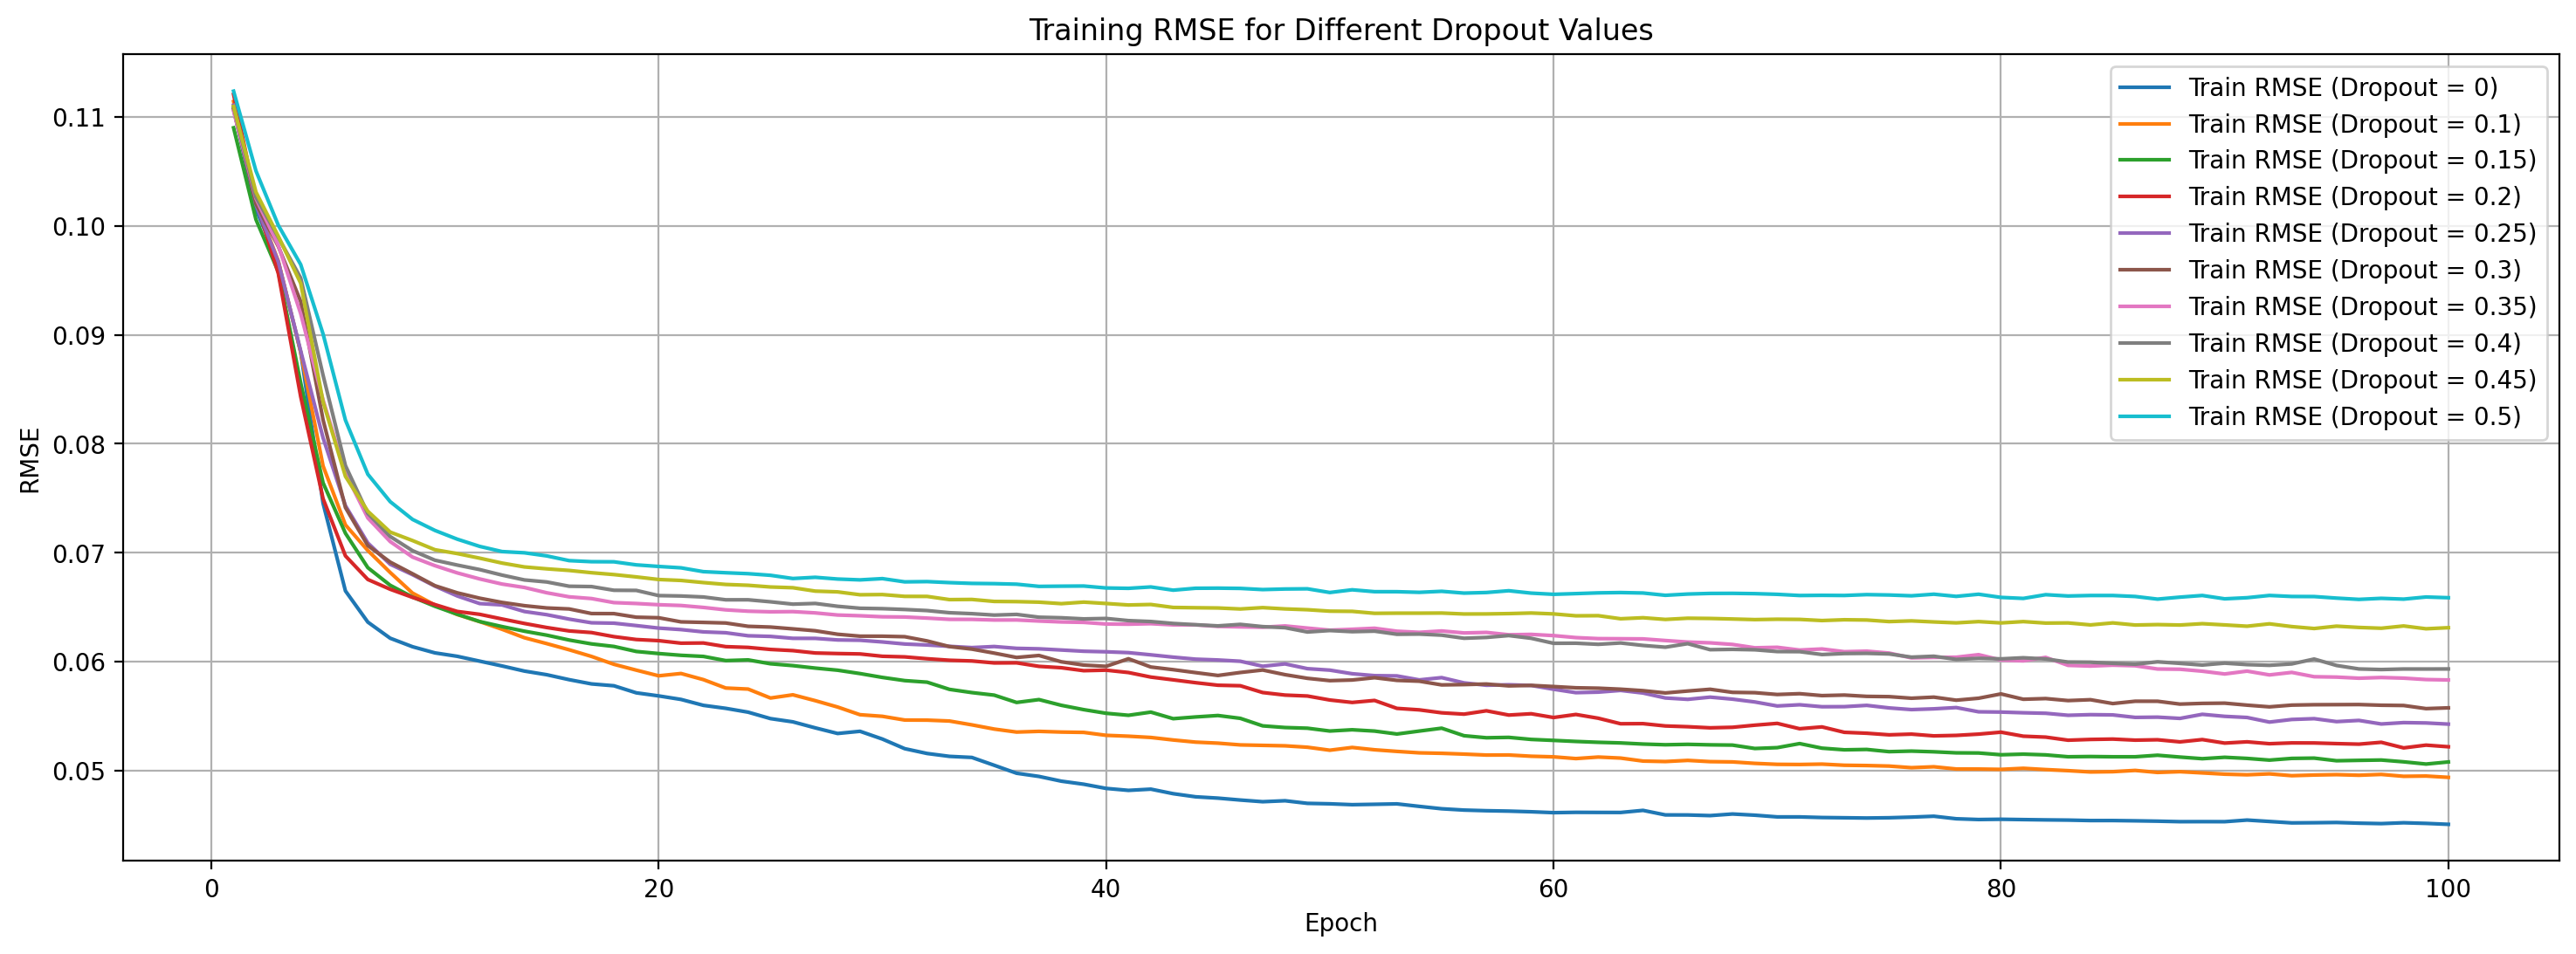

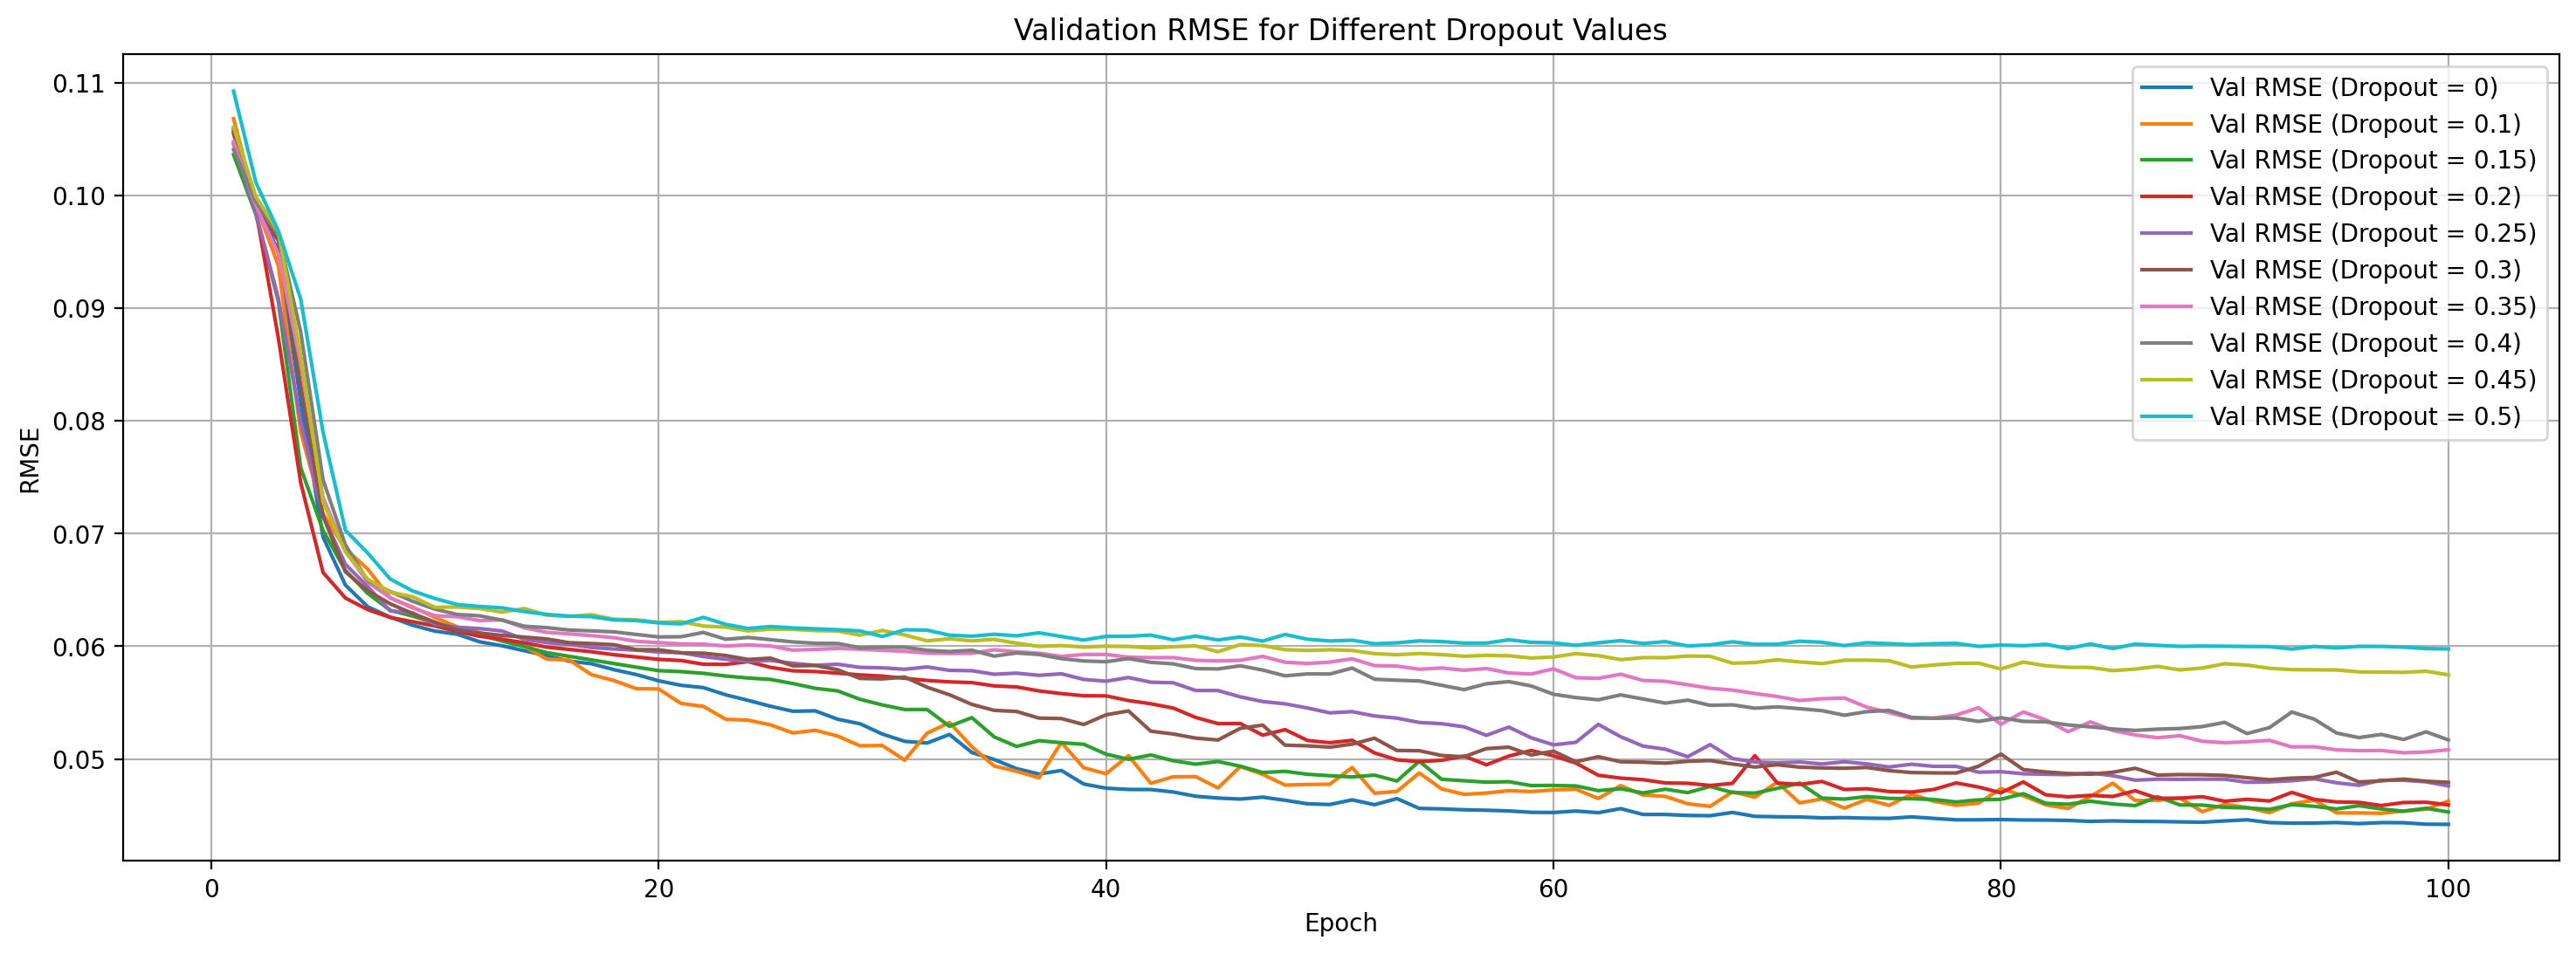

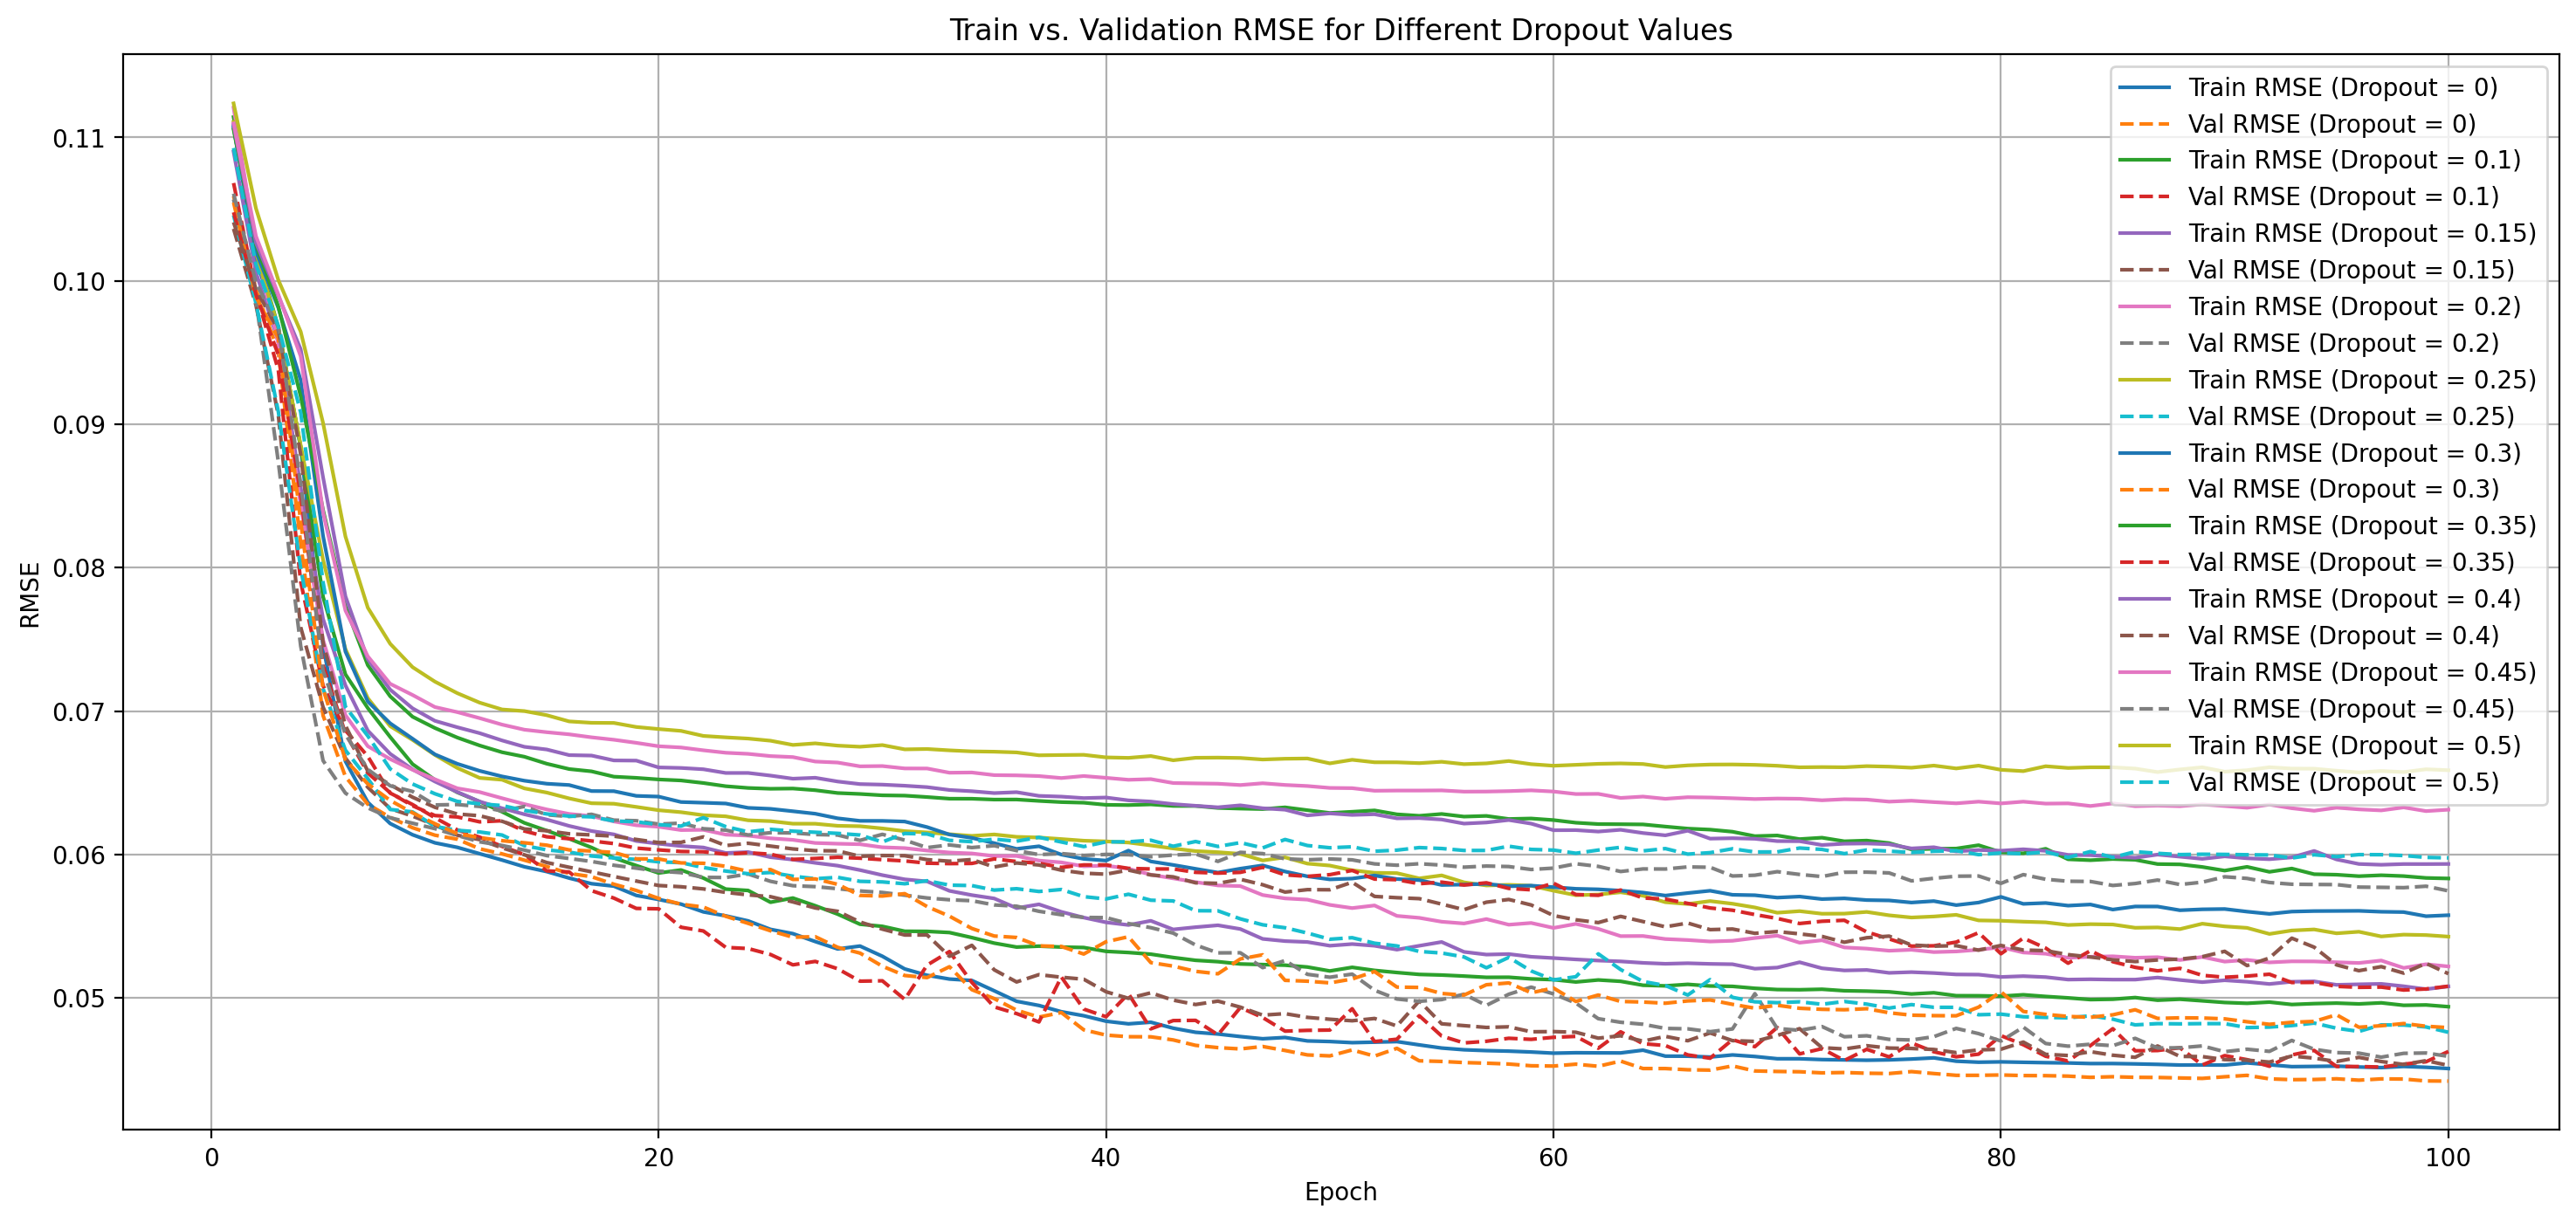

In [47]:
import matplotlib.pyplot as plt

dropout_values = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
train_rmse_results = {}
val_rmse_results = {}

for dropout in dropout_values:
    print(f"Training with dropout = {dropout}")
    conv1dfa = Conv1DAutoencoder_fa(latent_dims=20, dropout=dropout).to(device)
    train_rmse, val_rmse = train_fa_experiment(
        conv1dfa, fa_train_loader, fa_val_loader, epochs=100, lr=1e-3,
    )
    train_rmse_results[dropout] = train_rmse
    val_rmse_results[dropout] = val_rmse

# Plot 1: Training RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()

# Plot 2: Validation RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()

# Plot 3: Both Training and Validation RMSE
plt.figure(figsize=(18, 8))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        linestyle="--",
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train vs. Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()


Training with dropout = 0


TypeError: Conv1DAutoencoder_fa.forward() got an unexpected keyword argument 'dropout'

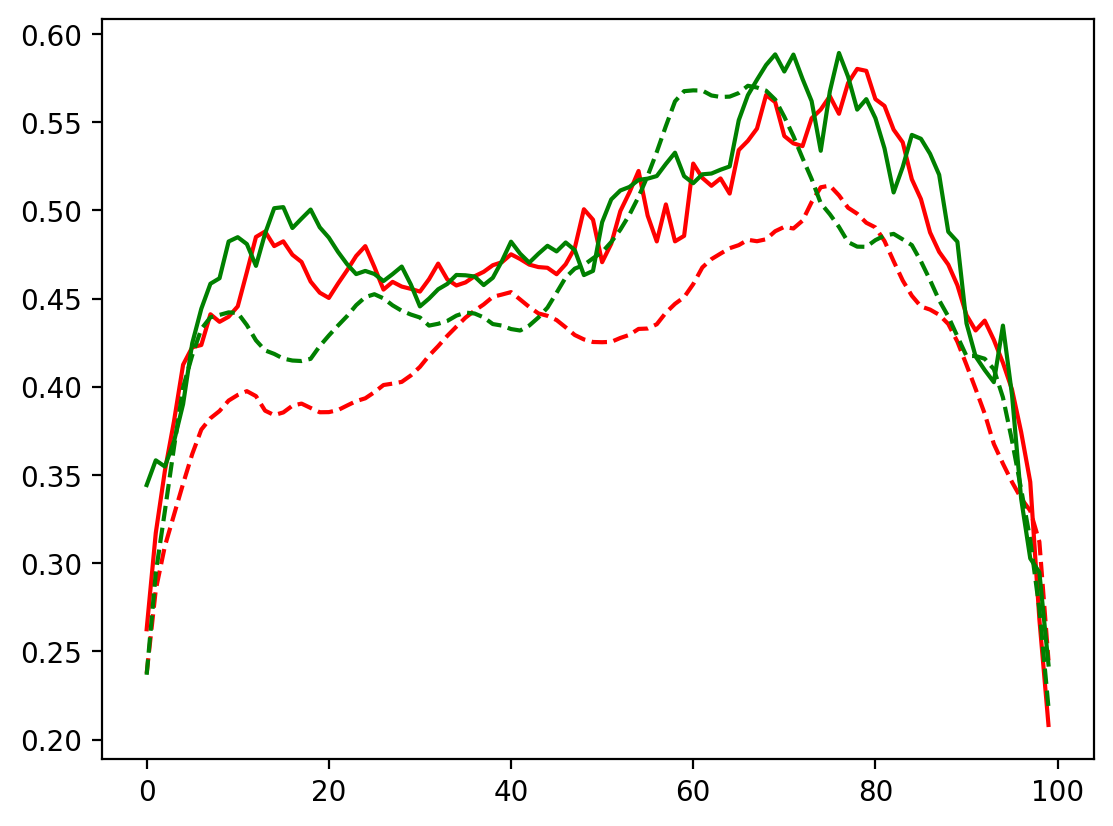

In [612]:
plt.plot(output3.cpu().detach().numpy().flatten()[0:100], color='red')
plt.plot(input_data.cpu().detach().numpy().flatten()[0:100], color='red', linestyle='dashed') 
plt.plot(output4.cpu().detach().numpy().flatten()[0:100], color='green')
plt.plot(input_data2.cpu().detach().numpy().flatten()[0:100], color='green', linestyle='dashed')

In [168]:
input_shape = (sequence_length, in_channels)
output_shape = input_shape
print(input_shape)

(48, 100)


In [177]:
in_channels = 48   # e.g. if your data is [batch, 48, 100]
latent_channels = 12
num_selected_tracts = 5
# vae = Conv1dAutoencoder(in_channels, latent_channels=latent_channels).to(device=device, dtype=torch.float32)
# vae = Conv1dAutoencoder_multiple_tract(in_channels=num_selected_tracts, latent_dim=20).to(device=device, dtype=torch.float32)
vae = Conv1dAutoencoderDeepSeek(latent_dim=20).to(device=device, dtype=torch.float32)
vae = train(vae, train_loader, val_loader, epochs = 200, lr=1e-3, use_lr_scheduler=True)
# vae = random_train_multiple_tracts(vae, train_loader, epochs=100, lr=1e-2, num_selected_tracts=num_selected_tracts, sigma=0.03)
print("Device for model parameters:", next(vae.parameters()).device)




/Users/samchou/miniconda3/envs/afq/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


AttributeError: 'tuple' object has no attribute 'size'

In [188]:
test_loader.dataset[0][0].unsqueeze(0).shape

torch.Size([1, 48, 100])

In [189]:
output = vae.forward(test_loader.dataset[0][0].unsqueeze(0).to(device))
output2 = vae.forward(test_loader.dataset[1][0].unsqueeze(0).to(device))

RuntimeError: slow_conv2d_forward_mps: input(device='cpu') and weight(device=mps:0')  must be on the same device

In [190]:
input_test = test_loader.dataset[0][0].unsqueeze(0).to(device)
output_test = vae(input_test)

input_test.shape, output_test.shape

RuntimeError: slow_conv2d_forward_mps: input(device='cpu') and weight(device=mps:0')  must be on the same device

In [191]:
# for i in range(48):
#     in_chan_1 = input_test.cpu().squeeze().detach().numpy()[i,:]
#     out_chan_1 = output_test.cpu().squeeze().detach().numpy()[i,:]

#     print(nn.MSELoss()(input_test, output_test))

#     plt.plot(in_chan_1, label='input')
#     plt.plot(out_chan_1, label='output')
#     plt.legend()
#     plt.show()

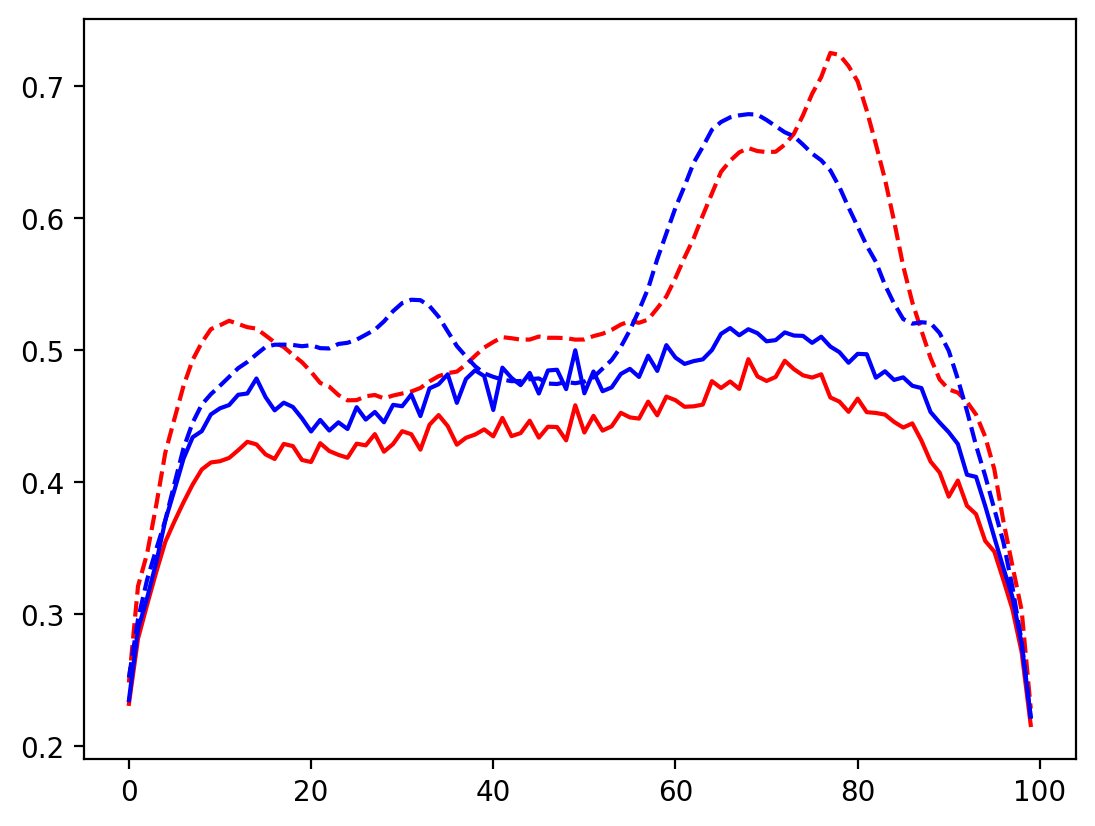

In [192]:
plt.plot(output.cpu().detach().numpy().flatten()[0:100], color='red')
plt.plot(dataset.X[0].flatten()[0:100], color='red', linestyle='dashed')
plt.plot(output2.cpu().detach().numpy().flatten()[0:100], color='blue')
plt.plot(dataset.X[1].flatten()[0:100], color='blue', linestyle='dashed')
# plt.plot(output3.cpu().detach().numpy().flatten()[0:100])

In [ ]:
def plot_latent_with_pca(vautoencoder, data_loader, target_index, num_batches=100):
    all_z = []
    all_targets = []
    
    for i, (x, y) in enumerate(data_loader):
        z = vautoencoder.encoder(x.to(device)).to('cpu').detach().numpy()
        z = z.reshape(z.shape[0], -1)  
        target = y[:, target_index].to('cpu').numpy()
        
        all_z.append(z)
        all_targets.append(target)
        
        if i >= num_batches:
            break
    
    all_z = np.vstack(all_z)
    all_targets = np.hstack(all_targets)
    
    #  PCA to reduce dimension to 2 dimensions 
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(all_z)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(z_pca[:, 0], z_pca[:, 1], c=all_targets, cmap='viridis', alpha=0.5)
    plt.colorbar(label=f"Target: {target_index}")
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f"PCA of Latent Space (Target Index: {target_index})")
    plt.show()


In [ ]:
def plot_latent(vautoencoder, data_loader, target_index, num_batches=100):
    plt.figure(figsize=(8, 6))
    
    for i, (x, y) in enumerate(data_loader):
        print(x.shape, y.shape)  
        z = vautoencoder.encoder(x.to(device)).to('cpu').detach().numpy()
        print("Latent space shape:", z.shape)  
        
        target = y[:, target_index].to('cpu').numpy()  # Shape: (batch_size,)
        print("Target column:", target.shape)
        
        plt.scatter(z[:, 0], z[:, 1], c=target, cmap='viridis', alpha=0.5)
        
        if i >= num_batches:
            break
    
    plt.colorbar(label=f"Target: {target_index}")
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(f"Latent Space Visualization (Target Index: {target_index})")
    
    plt.show()



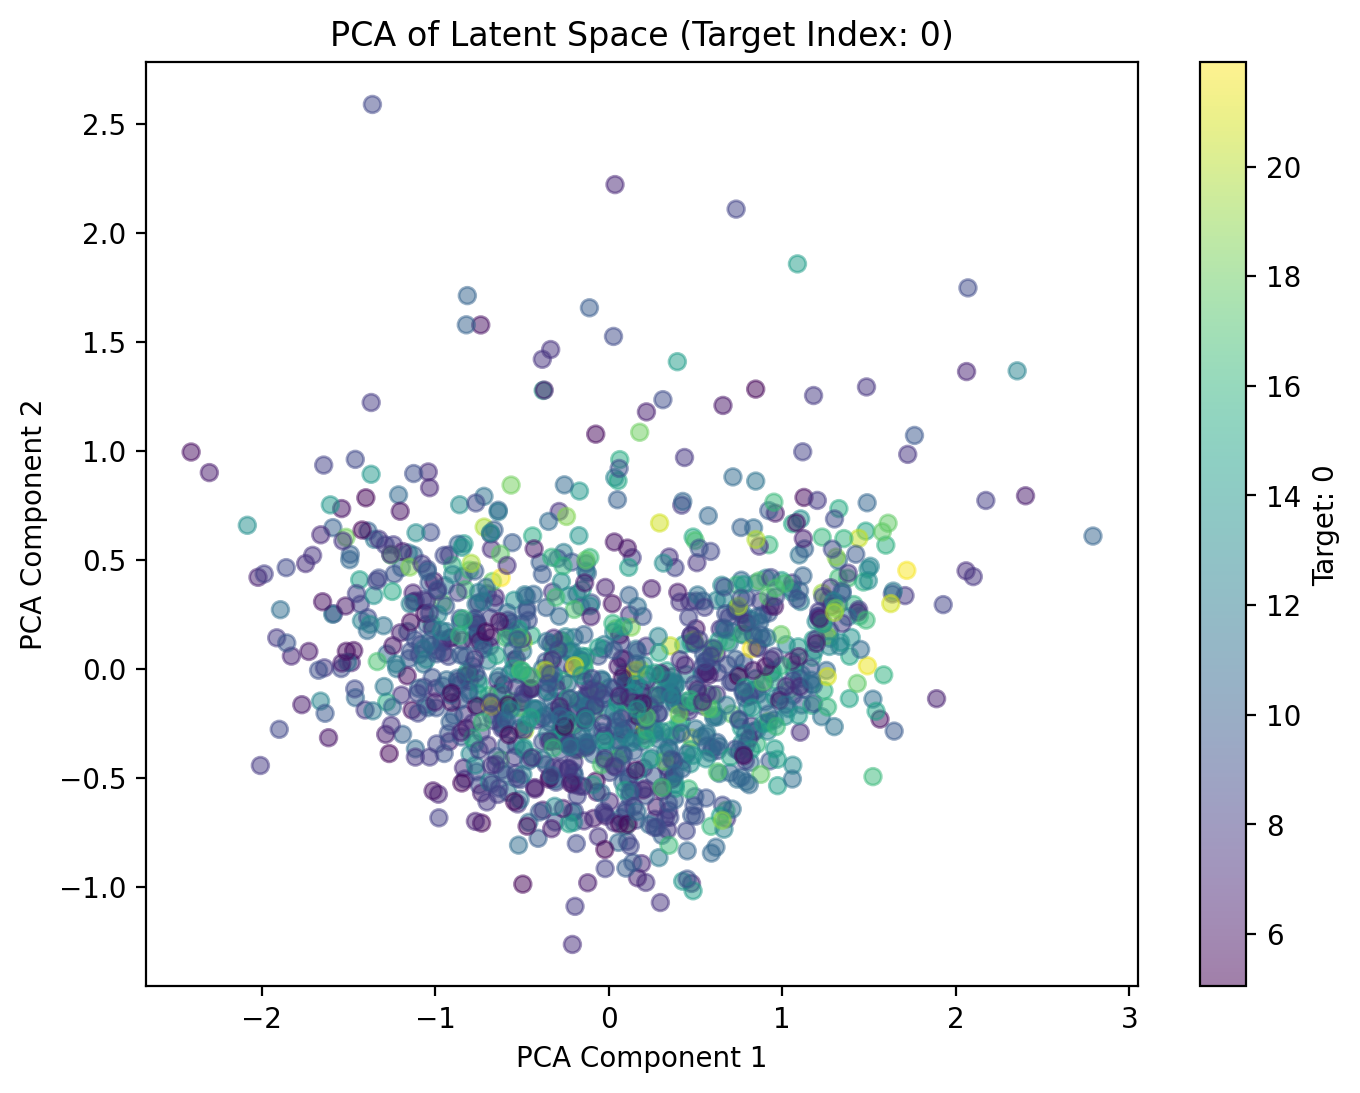

In [ ]:
plot_latent_with_pca(vae, train_loader, 0)

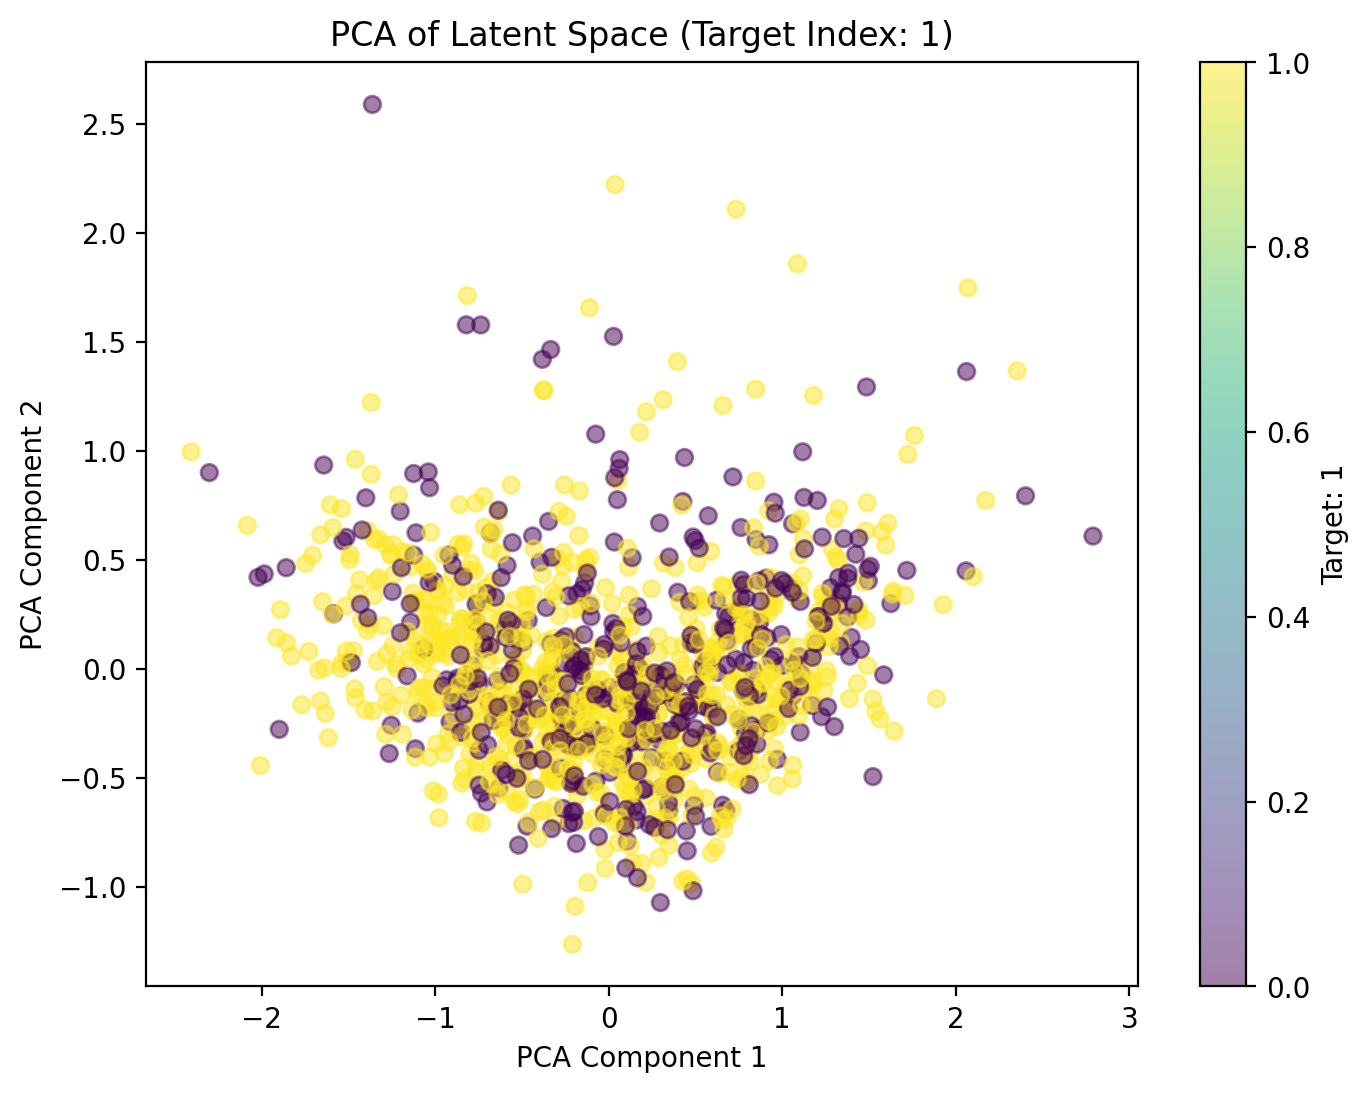

In [ ]:
plot_latent_with_pca(vae, train_loader, 1)

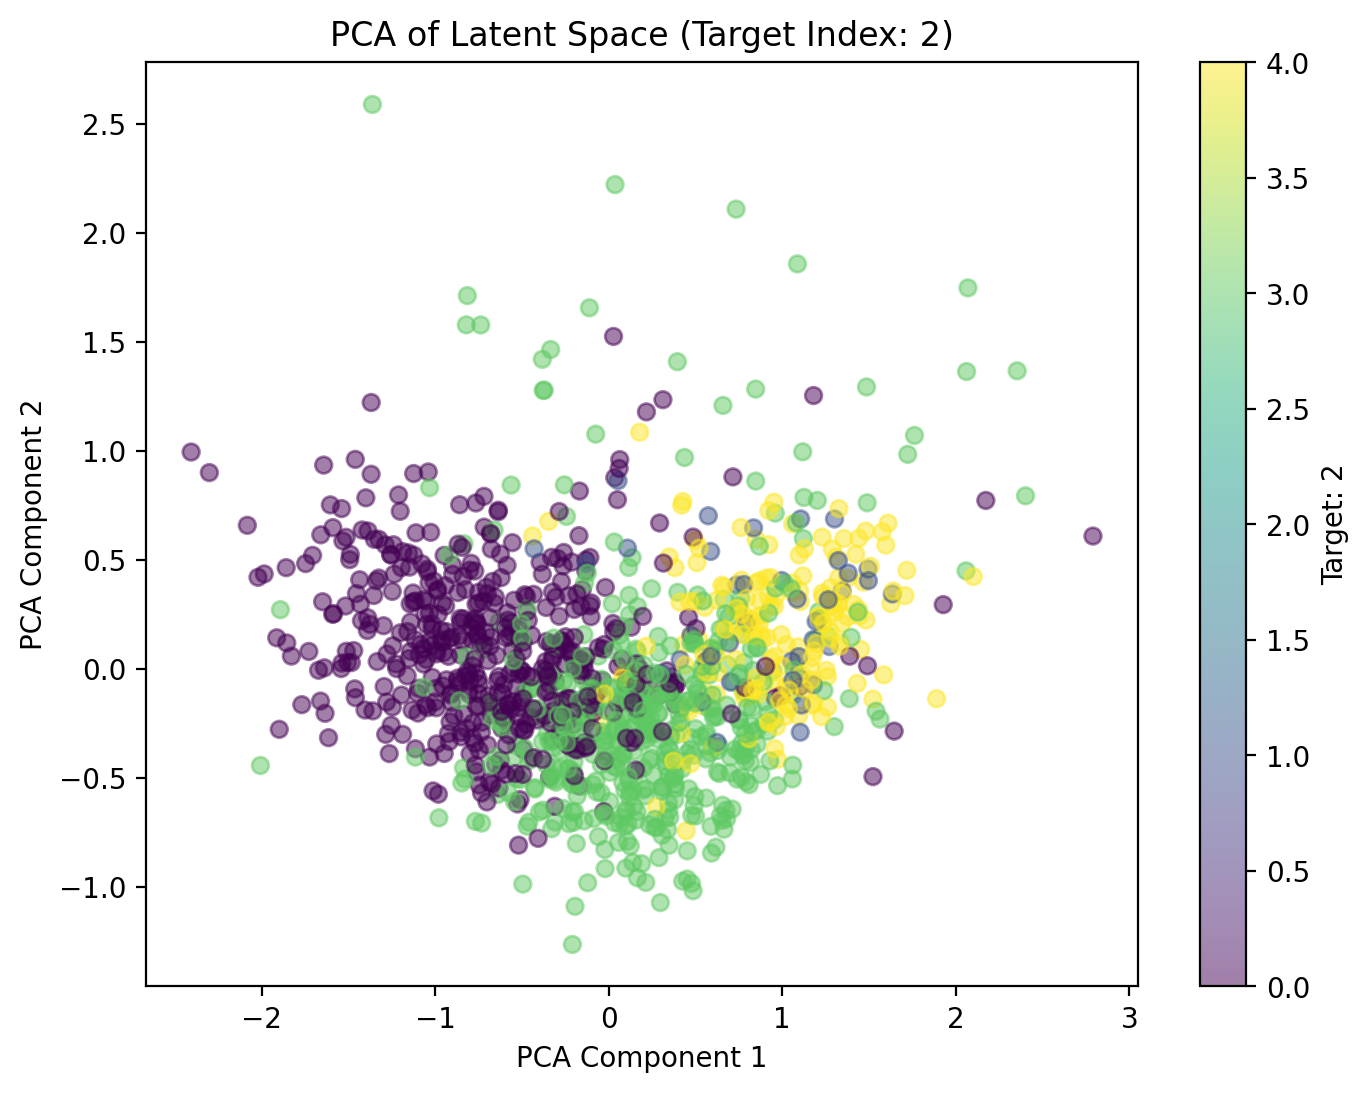

In [ ]:
plot_latent_with_pca(vae, train_loader, 2)